## **SISTEM DETEKSI PENIPUAN TRANSAKSI E-COMMERCE MENGGUNAKAN ALGORITMA GRADIENT BOOSTING**




 | Nama | NRP |
 | ---- | ---- |
 | Nathaniel Ryo Kurniadi | 5025221019 |

---

**Dr. Sarwosri, S.Kom, M.T.**


---

</br>

**Dataset**: <br>
https://www.kaggle.com/datasets/shriyashjagtap/fraudulent-e-commerce-transactions/data
<br>

**Model Building**: <br>
Gradient Boosting Machines (GBM), Extreme Gradient Boosting (XGboost), Categorical Boosting (CatBoost)

# **CRISP-DM**

Metodologi pengembangan model Menggunakan Cross Industry Standard Processf for Data Mining

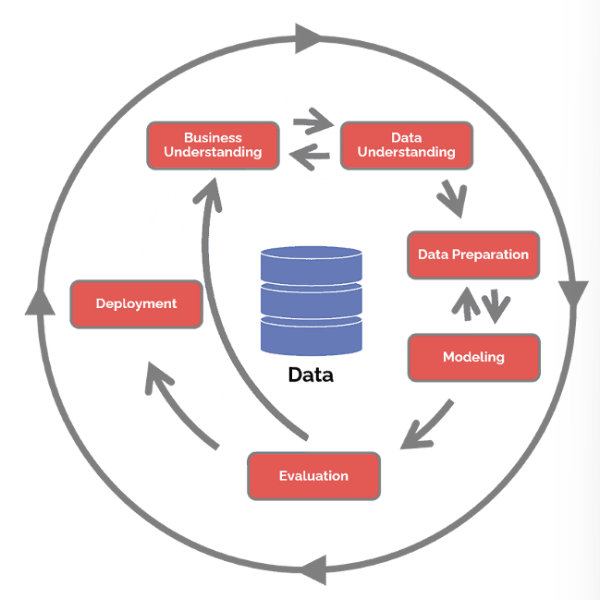

# **Import Library & Dataset**

In [2]:
# %pip install tensorflow
# %pip install kaggle
# %pip install networkx
# %pip install lightgbm 
# %pip install catboost 
# %pip install torch 
# %pip install torch-geometric

In [3]:
# import os
# import json
# cred = {"username":"nathanielryo","key":"a6af88b906ee9e800165dbaef8ed8bbd"}
# os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# api_token = cred


# with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
#     json.dump(api_token, f)

In [4]:
# ! kaggle datasets download -d shriyashjagtap/fraudulent-e-commerce-transactions

In [5]:
# import zipfile

# with zipfile.ZipFile("fraudulent-e-commerce-transactions.zip", "r") as zip_ref:
#     zip_ref.extractall("fraud_dataset")

In [6]:
# =========================
# Basic Libraries
# =========================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
from scipy import stats

# =========================
# Visualization
# =========================
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Preprocessing
# =========================
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split

# =========================
# Model Selection & Evaluation
# =========================
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score

# =========================
# Machine Learning Models
# =========================
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# =========================
# Deep Learning (PyTorch & PyG)
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool
from torch_geometric.loader import NeighborLoader

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


# **1. Business Understanding**

Perkembangan e-commerce di Indonesia menunjukan pertumbuhan pesat, pendapatan e-commerce diperkirakan mencapai **US$41,97 miliar pada 2025** dan meningkat hingga **US$60,95 miliar pada 2030** (CAGR 7,75%), dengan jumlah pengguna yang diproyeksikan mencapai **125,9 juta pada 2030** ([Statista, 2025](https://www.statista.com/outlook/emo/ecommerce/worldwide)).
<br /> <br />

**Tujuan** <br />
Proyek ini bertujuan untuk membangun mode machine learning berbasis **Gradient Boosting** yang dapat:
1. Mengklasifikasikan apakah suatu transaksi e-commerce termasuk fraud atau tidak.
2. Memberikan model sebagai pendukung keputusan yang dapat diintegrasikan pada proses validasi transaksi di sistem e-commerce.


# **2. Data Understanding**

## **Data Collection**

- Dataset diambil dari Kaggle: [Fraudulent E-Commerce Transactions](https://www.kaggle.com/datasets/shriyashjagtap/fraudulent-e-commerce-transactions/data)
- Data berisi transaksi pembelian customer e-commerce

## **Data Description**

Adapun fitur-fitur pada dataset kali ini adalah sebagai berikut:


| Kolom                  | Deskripsi                                                                                   |
| ---------------------- | ------------------------------------------------------------------------------------------- |
| **Transaction ID**     | ID unik untuk setiap transaksi.                                                             |
| **Customer ID**        | ID unik pelanggan yang melakukan transaksi.                                                 |
| **Transaction Amount** | Jumlah nominal uang dalam transaksi dalam USD ($).             |
| **Transaction Date**   | Tanggal transaksi dilakukan.                                                                |
| **Payment Method**     | Metode pembayaran yang digunakan (misalnya: kartu kredit, transfer bank,PayPal, dll).    |
| **Product Category**   | Kategori produk yang dibeli dalam transaksi (misalnya: elektronik, pakaian, dll).           |
| **Quantity**           | Jumlah unit produk yang dibeli dalam transaksi.                                             |
| **Customer Age**       | Usia pelanggan saat melakukan transaksi.                                                    |
| **Customer Location**  | Lokasi atau wilayah pelanggan.                                                              |
| **Device Used**        | Jenis perangkat yang digunakan pelanggan untuk melakukan transaksi (misalnya: mobile, dekstop,dll). |
| **IP Address**         | Alamat IP yang digunakan pelanggan saat transaksi.                                          |
| **Shipping Address**   | Alamat tujuan pengiriman produk.                                                            |
| **Billing Address**    | Alamat penagihan pelanggan                            |
| **Is Fraudulent**      | Label target: 1 = transaksi fraud, 0 = transaksi normal.                                    |
| **Account Age Days**   | Lama umur akun pelanggan dalam hitungan hari sejak dibuat.                                  |
| **Transaction Hour**   | Jam (0–23) ketika transaksi dilakukan.                                                      |                                                         |

<br>

## **Exploratory Data Analysis**

Untuk EDA dan proses training, kita akan menggunakan dataset dari csv `Fraudulent_E-Commerce_Transaction_Data` yang mempunyai lebih dari 1 juta entri

### **Intro EDA**

Pertama, kita akan memuat dataset dan menampilkannya untuk memastikan bahwa dataset berhasil dimuat dengan benar.

In [6]:
df = pd.read_csv("./fraud_dataset/Fraudulent_E-Commerce_Transaction_Data.csv")

In [7]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


In [8]:
df.tail()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16
1472951,d1a811a2-6015-47fa-95e5-0a5282755932,637d5ed1-a4af-4234-a1d9-a3791b6f1bb6,376.44,2024-02-19 18:57:20,bank transfer,clothing,5,34,Fullermouth,desktop,107.116.208.218,Unit 0520 Box 5911\nDPO AE 75554,Unit 0520 Box 5911\nDPO AE 75554,0,274,18


In [9]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  Transaction Hou

In [10]:
df.size

23567232

In [11]:
df.isnull().sum()

Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64

Karena tidak ada data yang kosong, maka tidak perlu ada kolom yang dihapus karena data kosong

In [12]:
num_cols = ["Transaction Amount", "Quantity", "Customer Age", "Account Age Days", "Transaction Hour"]

summary = pd.DataFrame({
    "Mean": df[num_cols].mean().round(2),
    "Median": df[num_cols].median().round(2),
    "Mode": df[num_cols].mode().iloc[0],
    "Std Dev": df[num_cols].std().round(2),
    "Min": df[num_cols].min(),
    "Max": df[num_cols].max()
})

print(summary)


                      Mean  Median  Mode  Std Dev   Min       Max
Transaction Amount  226.77  151.76  12.0   270.40  10.0  12701.75
Quantity              3.00    3.00   5.0     1.41   1.0      5.00
Customer Age         34.51   35.00  35.0    10.00 -16.0     86.00
Account Age Days    179.65  179.00  11.0   106.86   1.0    365.00
Transaction Hour     11.29   11.00   3.0     6.98   0.0     23.00


Customer dengan age negatif, perlu di drop datanya

### **Data Visualization**

#### **Distribusi Data**

count    1.472952e+06
mean     2.267683e+02
std      2.703951e+02
min      1.000000e+01
25%      6.861000e+01
50%      1.517600e+02
75%      2.960500e+02
max      1.270175e+04
Name: Transaction Amount, dtype: float64


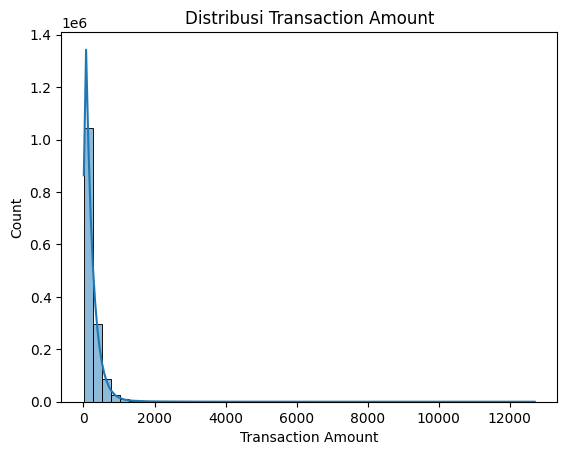

In [13]:
print(df["Transaction Amount"].describe())
sns.histplot(df["Transaction Amount"], bins=50, kde=True)
plt.title("Distribusi Transaction Amount")
plt.show()

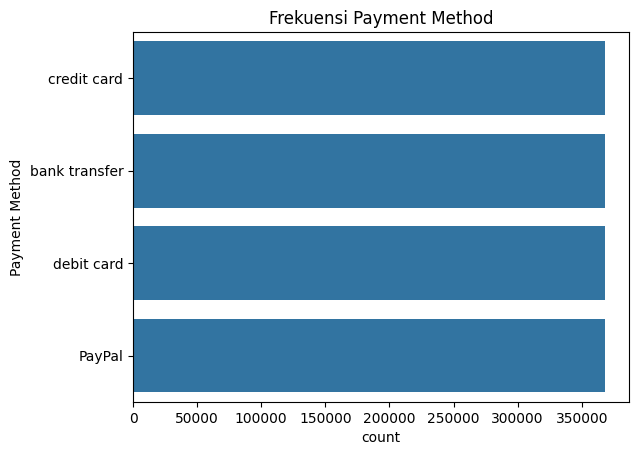

                 Count  Percentage
Payment Method                    
credit card     368429       25.01
bank transfer   368278       25.00
debit card      368277       25.00
PayPal          367968       24.98


In [14]:
sns.countplot(y="Payment Method", data=df, order=df["Payment Method"].value_counts().index)
plt.title("Frekuensi Payment Method")
plt.show()
payment_counts = df["Payment Method"].value_counts()
payment_percent = df["Payment Method"].value_counts(normalize=True) * 100
payment_summary = pd.DataFrame({
    "Count": payment_counts,
    "Percentage": payment_percent.round(2)
})
print(payment_summary)

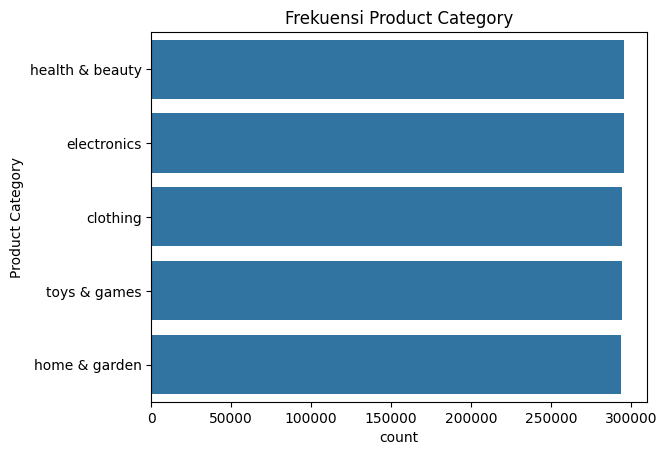

Product Category
health & beauty    295367
electronics        295294
clothing           294319
toys & games       294266
home & garden      293706
Name: count, dtype: int64


In [15]:
sns.countplot(y="Product Category", data=df, order=df["Product Category"].value_counts().index)
plt.title("Frekuensi Product Category")
plt.show()
print(df["Product Category"].value_counts())

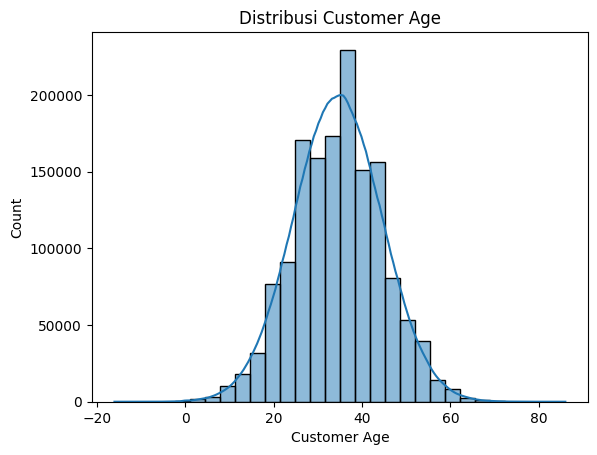

In [16]:
sns.histplot(df["Customer Age"], bins=30, kde=True)
plt.title("Distribusi Customer Age")
plt.show()

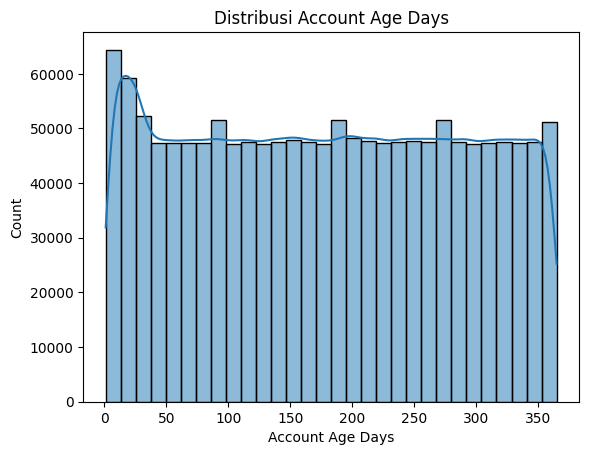

In [17]:
sns.histplot(df["Account Age Days"], bins=30, kde=True)
plt.title("Distribusi Account Age Days")
plt.show()

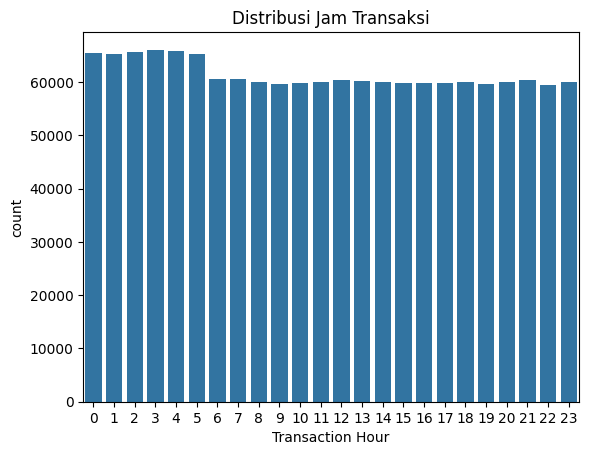

In [18]:
sns.countplot(x="Transaction Hour", data=df)
plt.title("Distribusi Jam Transaksi")
plt.show()

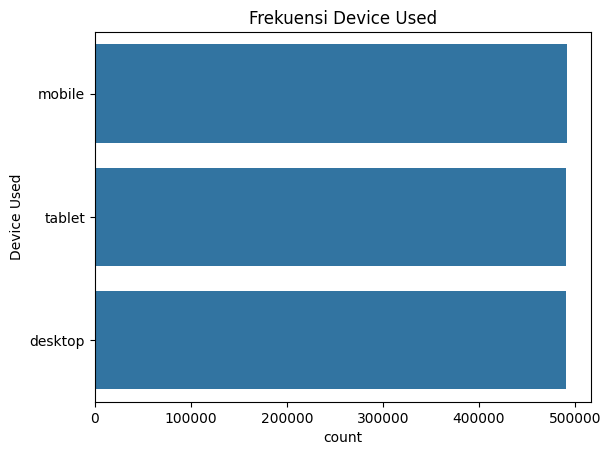

In [19]:
sns.countplot(y="Device Used", data=df, order=df["Device Used"].value_counts().index)
plt.title("Frekuensi Device Used")
plt.show()

#### **Analisis Variabel Target**

                 Count  Percentage (%)
Is Fraudulent                         
0              1399114           94.99
1                73838            5.01


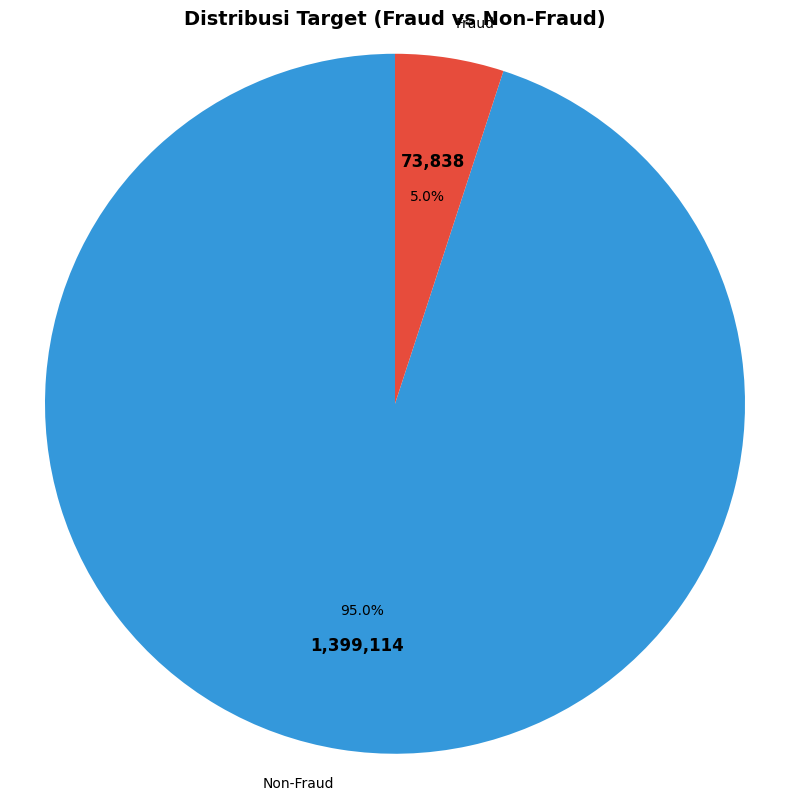

In [20]:
fraud_counts = df["Is Fraudulent"].value_counts()
fraud_percentages = df["Is Fraudulent"].value_counts(normalize=True) * 100

fraud_summary = pd.DataFrame({
    "Count": fraud_counts,
    "Percentage (%)": fraud_percentages.round(2)
})
print(fraud_summary)


plt.figure(figsize=(8, 8))

labels = ['Non-Fraud', 'Fraud']
sizes = fraud_counts.values
# Biru untuk Non-Fraud, Merah untuk Fraud
colors = ['#3498db', '#e74c3c']  
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

for i, (label, size) in enumerate(zip(labels, sizes)):
    angle = 90 + 360 * sum(sizes[:i]) / sum(sizes) + 180 * size / sum(sizes)
    plt.text(0.7 * np.cos(np.radians(angle)), 0.7 * np.sin(np.radians(angle)), 
             f'{size:,}', ha='center', va='center', fontsize=12, fontweight='bold')

plt.title("Distribusi Target (Fraud vs Non-Fraud)", fontsize=14, fontweight='bold')
plt.axis('equal') 
plt.tight_layout()
plt.show()

Karena Label non fraud sangat mendominasi, maka diperlukan teknik sampling (smote/undersampling)

**Heatmap**

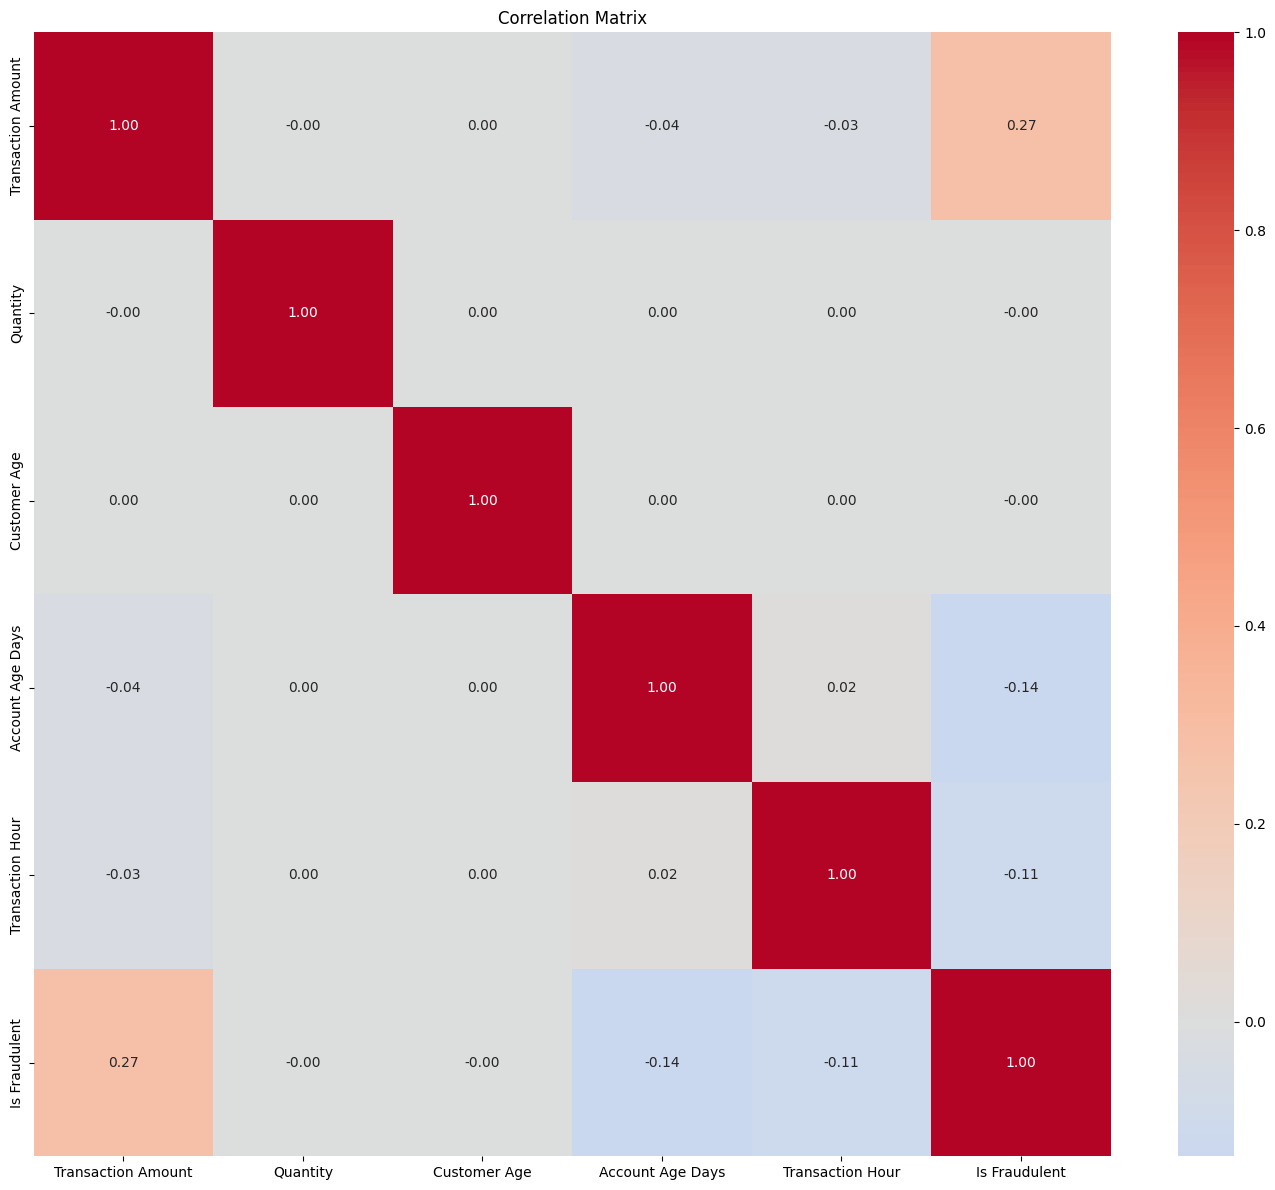

In [21]:
numerical_features = [
    "Transaction Amount",
    "Quantity",
    "Customer Age",
    "Account Age Days",
    "Transaction Hour"
]

categorical_features = [
    "Payment Method",
    "Product Category",
    "Customer Location",
    "Device Used"
]

plt.figure(figsize=(14, 12))
correlation_matrix = df[numerical_features + ['Is Fraudulent']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Data Preprocessing

### **Loading data**

In [7]:
df_train = pd.read_csv("./fraud_dataset/Fraudulent_E-Commerce_Transaction_Data.csv")
df_test = pd.read_csv("./fraud_dataset/Fraudulent_E-Commerce_Transaction_Data_2.csv")
df_train.head()


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


In [7]:
df_test.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,c12e07a0-8a06-4c0d-b5cc-04f3af688570,8ca9f102-02a4-4207-ab63-484e83a1bdf0,42.32,2024-03-24 23:42:43,PayPal,electronics,1,40,East Jameshaven,desktop,110.87.246.85,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,0,282,23
1,7d187603-7961-4fce-9827-9698e2b6a201,4d158416-caae-4b09-bd5b-15235deb9129,301.34,2024-01-22 00:53:31,credit card,electronics,3,35,Kingstad,tablet,14.73.104.153,"5230 Stephanie Forge\nCollinsbury, PR 81853","5230 Stephanie Forge\nCollinsbury, PR 81853",0,223,0
2,f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,ccae47b8-75c7-4f5a-aa9e-957deced2137,340.32,2024-01-22 08:06:03,debit card,toys & games,5,29,North Ryan,desktop,67.58.94.93,"195 Cole Oval\nPort Larry, IA 58422","4772 David Stravenue Apt. 447\nVelasquezside, ...",0,360,8
3,e9949bfa-194d-486b-84da-9565fca9e5ce,b04960c0-aeee-4907-b1cd-4819016adcef,95.77,2024-01-16 20:34:53,credit card,electronics,5,45,Kaylaville,mobile,202.122.126.216,"7609 Cynthia Square\nWest Brenda, NV 23016","7609 Cynthia Square\nWest Brenda, NV 23016",0,325,20
4,7362837c-7538-434e-8731-0df713f5f26d,de9d6351-b3a7-4bc7-9a55-8f013eb66928,77.45,2024-01-16 15:47:23,credit card,clothing,5,42,North Edwardborough,desktop,96.77.232.76,"2494 Robert Ramp Suite 313\nRobinsonport, AS 5...","2494 Robert Ramp Suite 313\nRobinsonport, AS 5...",0,116,15


### **Sample datas for experiment(don't run if want full data)**

In [8]:
np.random.seed(123)
sample_indices = np.random.choice(df_train.index, size=min(200000, len(df_train)), replace=False)
df_train_sample = df_train.loc[sample_indices].copy()

In [9]:
print(f"Training samples: {len(df_train_sample)}")
print(f"Test samples: {len(df_test)}")
print(f"\nClass distribution in training:")
print(df_train_sample['Is Fraudulent'].value_counts())
print(f"\nFraud rate: {df_train_sample['Is Fraudulent'].mean()*100:.2f}%")
print(f"\nClass distribution in test:")
print(df_test['Is Fraudulent'].value_counts())
print(f"\nFraud rate: {df_test['Is Fraudulent'].mean()*100:.2f}%")

Training samples: 200000
Test samples: 23634

Class distribution in training:
Is Fraudulent
0    189896
1     10104
Name: count, dtype: int64

Fraud rate: 5.05%

Class distribution in test:
Is Fraudulent
0    22412
1     1222
Name: count, dtype: int64

Fraud rate: 5.17%


## **Preprocess  Without GNN**

In [11]:
train_no_gnn = df_train_sample.copy()
test_no_gnn = df_test.copy()
# Drop label from test set
test_no_gnn.drop(columns=["Is Fraudulent"], inplace=True, errors="ignore")

# === Label column ===
label_col = "Is Fraudulent"

train_no_gnn = train_no_gnn.sort_values(["Customer ID", "Transaction Date"])
test_no_gnn = test_no_gnn.sort_values(["Customer ID", "Transaction Date"])
# train_no_gnn["Transaction Date"] = pd.to_datetime(train_no_gnn["Transaction Date"])
# test_no_gnn["Transaction Date"] = pd.to_datetime(test_no_gnn["Transaction Date"])

In [12]:
# ---- Train aggregates (computed ONLY on train set)
cust_grp = train_no_gnn.groupby("Customer ID")

train_agg = cust_grp["Transaction Amount"].agg(
    customer_tx_count="count",
    customer_avg_amount="mean",
    customer_std_amount="std"
)

# number of unique IPs per customer (train only)
train_agg_ip = train_no_gnn.groupby("Customer ID")["IP Address"].nunique().to_frame("customer_n_unique_ip")

# Merge all train aggregates
train_agg = train_agg.join(train_agg_ip)

# Fill std=0 for customers with only 1 transaction
train_agg["customer_std_amount"] = train_agg["customer_std_amount"].fillna(0)

test_agg = train_agg.copy()


### **Feature Engineering**

In [13]:
for df in (train_no_gnn, test_no_gnn):
    # Transaction amount-based features
    df["customer_tx_count"] = df["Customer ID"].map(train_agg["customer_tx_count"]).fillna(0)
    df["customer_avg_amount"] = df["Customer ID"].map(train_agg["customer_avg_amount"]).fillna(0)
    df["customer_std_amount"] = df["Customer ID"].map(train_agg["customer_std_amount"]).fillna(0)
    df["customer_n_unique_ip"] = df["Customer ID"].map(train_agg["customer_n_unique_ip"]).fillna(0)
    # Time-based features
    # df["prev_tx_time"] = df.groupby("Customer ID")["Transaction Date"].shift(1)
    # df["hours_since_prev_tx"] = (
    #     (df["Transaction Date"] - df["prev_tx_time"]).dt.total_seconds() / 3600
    # )
    # df["hours_since_prev_tx"] = df["hours_since_prev_tx"].fillna(-1)
    # Address match feature
    df['Is Address Same'] = np.where(df.get("Shipping Address","") == df.get("Billing Address",""), "1", "0")
    df['Is Weekend'] = np.where(pd.to_datetime(df['Transaction Date']).dt.dayofweek >=5, "1", "0")
# # Transaction_Size: compute bins from train and apply same to test (use train qcut bins)
# bins = pd.qcut(train_no_gnn['Transaction Amount'], q=5, retbins=True, duplicates='drop')[1]
# train_no_gnn['Transaction_Size'] = pd.cut(train_no_gnn['Transaction Amount'], bins=bins,
#                                           labels=['Very_Small','Small','Medium','Large','Very_Large'])
# test_no_gnn['Transaction_Size'] = pd.cut(test_no_gnn['Transaction Amount'], bins=bins,
#                                          labels=['Very_Small','Small','Medium','Large','Very_Large'])

# # Risk flags (quantile computed on train, applied to test using train's quantile if you want parity)
# high_amount_threshold = train_no_gnn['Transaction Amount'].quantile(0.95)
# high_quantity_threshold = train_no_gnn['Quantity'].quantile(0.95)


### **Drop Irrelevant Features**

In [14]:
cols_to_drop = ["Shipping Address","Billing Address","Transaction ID","Customer ID","IP Address","Customer Location","Transaction Date"]
train_no_gnn.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_no_gnn.drop(columns=cols_to_drop, inplace=True, errors='ignore')

### **Remove Outliers**

In [ ]:
if "Customer Age" in train_no_gnn.columns:
    age_mask = (train_no_gnn["Customer Age"] >= 10) & (train_no_gnn["Customer Age"] <= 60)
    train_no_gnn = train_no_gnn[age_mask].reset_index(drop=True)


Feature 'Transaction Amount' outliers found:
        Transaction Amount
6                   797.05
19                  672.37
75                 1708.45
79                  850.94
84                 1483.05
...                    ...
197752              980.22
197764             1315.80
197778              760.59
197874              683.87
197888             1030.73

[10574 rows x 1 columns]


In [16]:
for df in (train_no_gnn, test_no_gnn):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.datetime64):
            df.drop(columns=[col], inplace=True)

### **Encoding**

In [17]:
OHE_THRESHOLD = 20
cat_cols = train_no_gnn.select_dtypes(include=["object","category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != label_col]
num_cols = [col for col in train_no_gnn.columns if col not in cat_cols and col != 'Address Match' and col != label_col]
print("Categorical cols:", cat_cols)
print("Numerical cols:", num_cols)

train_encoded = []
test_encoded = []

for col in cat_cols:
    unique_vals = train_no_gnn[col].nunique()
    print(f"{col}: {unique_vals} unique values")

    if unique_vals <= OHE_THRESHOLD:
        # --- Use OneHotEncoder ---
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        train_enc = pd.DataFrame(
            encoder.fit_transform(train_no_gnn[[col]]),
            columns=[f"{col}_{cat}" for cat in encoder.categories_[0]],
            index=train_no_gnn.index
        )
        test_enc = pd.DataFrame(
            encoder.transform(test_no_gnn[[col]]),
            columns=[f"{col}_{cat}" for cat in encoder.categories_[0]],
            index=test_no_gnn.index
        )
    else:
        # --- Use LabelEncoder ---
        encoder = LabelEncoder()
        # Align unknown labels in test set
        train_enc = train_no_gnn[[col]].copy()
        test_enc = test_no_gnn[[col]].copy()

        # Fit encoder on train + known test values
        encoder.fit(pd.concat([train_enc[col], test_enc[col]], axis=0).astype(str))

        train_enc[col] = encoder.transform(train_enc[col].astype(str))
        test_enc[col] = encoder.transform(test_enc[col].astype(str))

    train_encoded.append(train_enc)
    test_encoded.append(test_enc)

# Merge encoded categorical data
train_cats_encoded = pd.concat(train_encoded, axis=1)
test_cats_encoded = pd.concat(test_encoded, axis=1)
print("Encoded categorical shape (train):", train_cats_encoded.shape)
print("Encoded categorical shape (test):", test_cats_encoded.shape)

Categorical cols: ['Payment Method', 'Product Category', 'Device Used', 'Is Address Same', 'Is Weekend']
Numerical cols: ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'customer_tx_count', 'customer_avg_amount', 'customer_std_amount', 'customer_n_unique_ip']
Payment Method: 4 unique values
Product Category: 5 unique values
Device Used: 3 unique values
Is Address Same: 2 unique values
Is Weekend: 2 unique values
Encoded categorical shape (train): (197890, 16)
Encoded categorical shape (test): (23634, 16)


### **Train-Test Split**

In [18]:
# Concatenate encoded categorical + numerical features
X_all = pd.concat([train_no_gnn[num_cols].reset_index(drop=True),
                   train_cats_encoded.reset_index(drop=True)], axis=1)
X_test = pd.concat([test_no_gnn[num_cols].reset_index(drop=True),
                    test_cats_encoded.reset_index(drop=True)], axis=1)

y_all = train_no_gnn[label_col].astype(int).reset_index(drop=True)

# Align columns (fill missing cols)
X_test = X_test.reindex(columns=X_all.columns, fill_value=0)

print("X_all.shape, y_all.shape:", X_all.shape, y_all.shape)

# === Split before SMOTE (to prevent data leakage) ===
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=42
)


X_all.shape, y_all.shape: (197890, 25) (197890,)


### **SMOTE**

In [19]:
# === Apply SMOTE only on training set ===
USE_SMOTE = True  # toggle on/off as needed

if USE_SMOTE:
    print("Applying SMOTE on training set only...")
    sm = SMOTE(random_state=42,sampling_strategy=0.2)
    X_train_res_np, y_train_res_np = sm.fit_resample(X_train, y_train)
    X_train_res = pd.DataFrame(X_train_res_np, columns=X_train.columns)
    y_train_res = pd.Series(y_train_res_np, name=y_train.name)
    print("After SMOTE class counts (train_res):", np.bincount(y_train_res))
else:
    print("Skipping SMOTE (using original training data).")
    X_train_res, y_train_res = X_train.copy(), y_train.copy()

print("Validation class counts:", np.bincount(y_val))
print("Shapes -> Train:", X_train_res.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)

Applying SMOTE on training set only...
After SMOTE class counts (train_res): [150325  30065]
Validation class counts: [37581  1997]
Shapes -> Train: (180390, 25) | Val: (39578, 25) | Test: (23634, 25)


### **Undersampling**

In [20]:
print("Applying ENN...")
enn = EditedNearestNeighbours()
X_train_clean_np, y_train_clean_np = enn.fit_resample(X_train_res, y_train_res)

X_train_clean = pd.DataFrame(X_train_clean_np, columns=X_train_res.columns)
y_train_clean = pd.Series(y_train_clean_np, name=y_train.name)

print("After ENN class counts:", np.bincount(y_train_clean))

print("Validation class counts:", np.bincount(y_val))
print("Shapes -> Train:", X_train_clean.shape,
      "| Val:", X_val.shape, "| Test:", X_test.shape)
X_train_clean.head().T

Applying ENN...
After ENN class counts: [123972  30065]
Validation class counts: [37581  1997]
Shapes -> Train: (154037, 25) | Val: (39578, 25) | Test: (23634, 25)


,0,1,2,3,4
Transaction Amount,63.37,51.36,127.77,99.6,131.81
Quantity,2.00,1.00,2.00,5.0,5.00
Customer Age,32.00,48.00,35.00,14.0,44.00
Account Age Days,21.00,275.00,301.00,132.0,92.00
Transaction Hour,16.00,3.00,1.00,11.0,5.00
customer_tx_count,1.00,1.00,1.00,1.0,1.00
customer_avg_amount,63.37,51.36,127.77,99.6,131.81
customer_std_amount,0.00,0.00,0.00,0.0,0.00
customer_n_unique_ip,1.00,1.00,1.00,1.0,1.00
Payment Method_PayPal,1.00,0.00,1.00,0.0,0.00


### **Scaling**

In [ ]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_clean),
    columns=X_train_clean.columns,
    index=X_train_clean.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [ ]:
print("Final shapes:")
print(" X_train_scaled:", X_train_scaled.shape)
print(" X_val_scaled:  ", X_val_scaled.shape)
print(" X_test_scaled: ", X_test_scaled.shape)
print(" y_train_res:", np.bincount(y_train_res), " y_val_res:", np.bincount(y_val))

Final shapes:
 X_train_scaled: (77217, 23)
 X_val_scaled:   (19791, 23)
 X_test_scaled:  (23634, 23)
 y_train_res: [75142 15028]  y_val_res: [18785  1006]


## **Preprocess With GNN**

In [10]:
train_gnn = df_train_sample.copy()
test_gnn = df_test.copy()
test_gnn.drop(columns=["Is Fraudulent"], inplace=True, errors="ignore")

label_col = "Is Fraudulent"
train_gnn = train_gnn.sort_values(["Customer ID", "Transaction Date"])
test_gnn = test_gnn.sort_values(["Customer ID", "Transaction Date"])


### **Data Cleaning**

In [12]:
def clean_data(df_raw):
    """
    Clean transaction dataset from invalid and noisy data.
    
    Args:
        df_raw: Raw transaction DataFrame
        
    Returns:
        df_clean: Cleaned transaction DataFrame
    """
    df_clean = df_raw.copy()
    
    # 1. Handle duplicate data
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    duplicates_removed = initial_rows - len(df_clean)
    print(f"Duplicates removed: {duplicates_removed}")
    
    # 2. Handle missing values
    missing_before = df_clean.isnull().sum().sum()
    if missing_before > 0:
        # Implement missing value handling strategy
        # For this dataset, no missing values exist
        df_clean = df_clean.dropna()
        print(f"Missing values handled: {missing_before}")
    else:
        print("No missing values found")
    
    # 3. Standardize format
    # Check for datetime columns
    if 'Transaction Date' in df_clean.columns:
        df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'])
    print("Data format standardized")
    
    # 4. Handle outliers using IQR method
    outlier_features = ['Quantity', 'Transaction Amount', 'Customer Age']
    
    for feature in outlier_features:
        if feature in df_clean.columns:
            Q1 = df_clean[feature].quantile(0.25)
            Q3 = df_clean[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            if feature == 'Customer Age':
                # Remove negative ages (logically impossible)
                before = len(df_clean)
                df_clean = df_clean[df_clean[feature] >= 0]
                removed = before - len(df_clean)
                print(f"{feature}: Removed {removed} negative values")
            else:
                # Keep outliers for Quantity and Transaction Amount
                outliers = ((df_clean[feature] < lower_bound) | 
                           (df_clean[feature] > upper_bound)).sum()
                print(f"{feature}: {outliers} outliers detected (retained)")
    
    print(f"Final dataset size: {len(df_clean)} rows")
    return df_clean

train_gnn_clean = clean_data(train_gnn)

Duplicates removed: 0
No missing values found
Data format standardized
Quantity: 0 outliers detected (retained)
Transaction Amount: 10689 outliers detected (retained)
Customer Age: Removed 32 negative values
Final dataset size: 199968 rows


### **Feature Engineering**

In [ ]:
def feature_engineering(df_clean, is_train=True, encoders=None, scaler=None):
    df_engineered = df_clean.copy()
    encoders_dict = {} if encoders is None else encoders

    # 1. Feature Extraction    
    # Temporal features from Transaction Date
    if 'Transaction Date' in df_engineered.columns:
        df_engineered['Transaction Date'] = pd.to_datetime(df_engineered['Transaction Date'])
        df_engineered['Day_of_Week'] = df_engineered['Transaction Date'].dt.dayofweek
        df_engineered['Is_Weekend'] = (df_engineered['Day_of_Week'] >= 5).astype(int)
    # Address matching feature
    if 'Shipping Address' in df_engineered.columns and 'Billing Address' in df_engineered.columns:
        df_engineered['Is_Address_Same'] = (
            df_engineered['Shipping Address'] == df_engineered['Billing Address']
        ).astype(int)
    print(f"Features extracted: Day_of_Week, Is_Weekend, Is_Address_Same")

    # 2. Drop Irrelevant Features
    irrelevant_features = ['Transaction ID', 'Customer ID', 'IP Address', 
                          'Customer Location', 'Transaction Date']
    features_to_drop = [f for f in irrelevant_features if f in df_engineered.columns]
    df_engineered = df_engineered.drop(columns=features_to_drop)
    print(f"Dropped: {features_to_drop}")
    
    # 3. Feature Encoding
    # Separate label column
    label_col = 'Is Fraudulent'
    y = None
    if label_col in df_engineered.columns:
        y = df_engineered[label_col]
        df_engineered = df_engineered.drop(columns=[label_col])
    
    # Identify categorical columns
    cat_cols = df_engineered.select_dtypes(include=['object', 'category']).columns.tolist()
    OHE_THRESHOLD = 20
    encoded_dfs = []
    for col in cat_cols:
        unique_count = df_engineered[col].nunique()
        if unique_count < OHE_THRESHOLD:
            # One-Hot Encoding
            if is_train:
                encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
                encoded = encoder.fit_transform(df_engineered[[col]])
                encoders_dict[col] = encoder
            else:
                encoder = encoders_dict[col]
                encoded = encoder.transform(df_engineered[[col]])
            
            encoded_df = pd.DataFrame(
                encoded,
                columns=[f"{col}_{cat}" for cat in encoder.categories_[0]],
                index=df_engineered.index
            )
            print(f"  {col}: One-Hot Encoded ({unique_count} categories)")
        else:
            # Label Encoding
            if is_train:
                encoder = LabelEncoder()
                encoder.fit(df_engineered[col].astype(str))
                encoders_dict[col] = encoder
            else:
                encoder = encoders_dict[col]
            encoded_df = pd.DataFrame(
                {col: encoder.transform(df_engineered[col].astype(str))},
                index=df_engineered.index
            )
            print(f"  {col}: Label Encoded ({unique_count} categories)")
        encoded_dfs.append(encoded_df)
    # Remove original categorical columns and add encoded ones
    df_engineered = df_engineered.drop(columns=cat_cols)
    if encoded_dfs:
        df_engineered = pd.concat([df_engineered] + encoded_dfs, axis=1)   
    # 4. Feature Transformation (Scaling)
    numerical_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
    
    if is_train:
        scaler_fitted = MinMaxScaler()
        df_engineered[numerical_cols] = scaler_fitted.fit_transform(df_engineered[numerical_cols])
    else:
        scaler_fitted = scaler
        df_engineered[numerical_cols] = scaler_fitted.transform(df_engineered[numerical_cols])
    
    print(f"Scaled {len(numerical_cols)} numerical features to [0, 1]")
    
    # Add label back if it existed
    if y is not None:
        df_engineered[label_col] = y
    
    print(f"Final feature count: {len(df_engineered.columns)}")
    
    if is_train:
        return df_engineered, encoders_dict, scaler_fitted
    else:
        return df_engineered

### **Drop Irrelevant Features**

In [26]:
# Don't forget to save addresses for graph construction
shipping_address = train_gnn["Shipping Address"].copy()
billing_address = train_gnn["Billing Address"].copy()
cols_to_drop = ["Transaction ID","Customer ID","IP Address",
                "Customer Location","Transaction Date"]
train_gnn.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_gnn.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [27]:
for df in (train_gnn, test_gnn):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.datetime64):
            df.drop(columns=[col], inplace=True)

### **Remove Outliers**

In [28]:
# Keep age between 10-60
if "Customer Age" in train_gnn.columns:
    age_mask = (train_gnn["Customer Age"] >= 10) & (train_gnn["Customer Age"] <= 60)
    train_gnn = train_gnn[age_mask].reset_index(drop=True)
    train_customer_ids_gnn = train_customer_ids_gnn[age_mask].reset_index(drop=True)
    train_ips_gnn = train_ips_gnn[age_mask].reset_index(drop=True)

if "Customer Age" in test_gnn.columns:
    age_mask = (test_gnn["Customer Age"] >= 10) & (test_gnn["Customer Age"] <= 60)
    test_gnn = test_gnn[age_mask].reset_index(drop=True)
    test_customer_ids_gnn = test_customer_ids_gnn[age_mask].reset_index(drop=True)
    test_ips_gnn = test_ips_gnn[age_mask].reset_index(drop=True)

print(f"After filtering: train_gnn={len(train_gnn)}, customer_ids={len(train_customer_ids_gnn)}")

After filtering: train_gnn=197890, customer_ids=197890


In [29]:
# Remove datetime columns before modeling
for df in (train_gnn, test_gnn):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.datetime64):
            df.drop(columns=[col], inplace=True)

### **Encoding**

In [30]:
OHE_THRESHOLD = 20
cat_cols_gnn = train_gnn.select_dtypes(include=["object","category"]).columns.tolist()
cat_cols_gnn = [c for c in cat_cols_gnn if c != label_col]
num_cols_gnn = [col for col in train_gnn.columns if col not in cat_cols_gnn and col != 'Address Match' and col != label_col]

print("Categorical cols:", cat_cols_gnn)
print("Numerical cols:", num_cols_gnn)

train_gnn_encoded = []
test_gnn_encoded = []

for col in cat_cols_gnn:
    unique_vals = train_gnn[col].nunique()
    print(f"{col}: {unique_vals} unique values")

    if unique_vals <= OHE_THRESHOLD:
        # Use OneHotEncoder
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        train_enc = pd.DataFrame(
            encoder.fit_transform(train_gnn[[col]]),
            columns=[f"{col}_{cat}" for cat in encoder.categories_[0]],
            index=train_gnn.index
        )
        test_enc = pd.DataFrame(
            encoder.transform(test_gnn[[col]]),
            columns=[f"{col}_{cat}" for cat in encoder.categories_[0]],
            index=test_gnn.index
        )
    else:
        # Use LabelEncoder
        encoder = LabelEncoder()
        train_enc = train_gnn[[col]].copy()
        test_enc = test_gnn[[col]].copy()

        # Fit encoder on train + known test values
        encoder.fit(pd.concat([train_enc[col], test_enc[col]], axis=0).astype(str))

        train_enc[col] = encoder.transform(train_enc[col].astype(str))
        test_enc[col] = encoder.transform(test_enc[col].astype(str))

    train_gnn_encoded.append(train_enc)
    test_gnn_encoded.append(test_enc)

# Merge encoded categorical data
train_cats_gnn_encoded = pd.concat(train_gnn_encoded, axis=1)
test_cats_gnn_encoded = pd.concat(test_gnn_encoded, axis=1)
print("Encoded categorical shape (train):", train_cats_gnn_encoded.shape)
print("Encoded categorical shape (test):", test_cats_gnn_encoded.shape)

Categorical cols: ['Payment Method', 'Product Category', 'Device Used', 'Shipping Address', 'Billing Address', 'Address Match']
Numerical cols: ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'customer_tx_count', 'customer_avg_amount', 'customer_std_amount', 'customer_n_unique_ip']
Payment Method: 4 unique values
Product Category: 5 unique values
Device Used: 3 unique values
Shipping Address: 197890 unique values
Billing Address: 197890 unique values
Address Match: 2 unique values
Encoded categorical shape (train): (197890, 16)
Encoded categorical shape (test): (23368, 16)


### **Train-Test Split**

In [31]:
X_all_gnn = pd.concat([train_gnn[num_cols_gnn].reset_index(drop=True),
                       train_cats_gnn_encoded.reset_index(drop=True)], axis=1)
X_test_gnn = pd.concat([test_gnn[num_cols_gnn].reset_index(drop=True),
                        test_cats_gnn_encoded.reset_index(drop=True)], axis=1)

y_all_gnn = train_gnn[label_col].astype(int).reset_index(drop=True)

# Align columns (fill missing cols)
X_test_gnn = X_test_gnn.reindex(columns=X_all_gnn.columns, fill_value=0)

print("X_all_gnn.shape, y_all_gnn.shape:", X_all_gnn.shape, y_all_gnn.shape)

X_train_gnn, X_val_gnn, y_train_gnn, y_val_gnn = train_test_split(
    X_all_gnn, y_all_gnn,
    test_size=0.2,
    stratify=y_all_gnn,
    random_state=42
)

X_all_gnn.shape, y_all_gnn.shape: (197890, 25) (197890,)


### **SMOTE**

In [32]:
USE_SMOTE = True

if USE_SMOTE:
    print("Applying SMOTE on training set only...")
    sm = SMOTE(random_state=42, sampling_strategy=0.2)
    X_train_res_gnn_np, y_train_res_gnn_np = sm.fit_resample(X_train_gnn, y_train_gnn)
    X_train_res_gnn = pd.DataFrame(X_train_res_gnn_np, columns=X_train_gnn.columns)
    y_train_res_gnn = pd.Series(y_train_res_gnn_np, name=y_train_gnn.name)
    print("After SMOTE class counts (train_res_gnn):", np.bincount(y_train_res_gnn))
else:
    print("Skipping SMOTE (using original training data).")
    X_train_res_gnn, y_train_res_gnn = X_train_gnn.copy(), y_train_gnn.copy()

print("Validation class counts:", np.bincount(y_val_gnn))
print("Shapes -> Train:", X_train_res_gnn.shape, "| Val:", X_val_gnn.shape, "| Test:", X_test_gnn.shape)

Applying SMOTE on training set only...
After SMOTE class counts (train_res_gnn): [150325  30065]
Validation class counts: [37581  1997]
Shapes -> Train: (180390, 25) | Val: (39578, 25) | Test: (23368, 25)


### **Undersampling**

In [33]:
print("Applying ENN...")
enn = EditedNearestNeighbours()
X_train_clean_gnn_np, y_train_clean_gnn_np = enn.fit_resample(X_train_res_gnn, y_train_res_gnn)

X_train_clean_gnn = pd.DataFrame(X_train_clean_gnn_np, columns=X_train_res_gnn.columns)
y_train_clean_gnn = pd.Series(y_train_clean_gnn_np, name=y_train_gnn.name)

print("After ENN class counts:", np.bincount(y_train_clean_gnn))
print("Shapes -> Train:", X_train_clean_gnn.shape, "| Val:", X_val_gnn.shape, "| Test:", X_test_gnn.shape)

Applying ENN...
After ENN class counts: [118983  30065]
Shapes -> Train: (149048, 25) | Val: (39578, 25) | Test: (23368, 25)


### **Scaling**

In [34]:
scaler_gnn = MinMaxScaler()

X_train_scaled_gnn = pd.DataFrame(
    scaler_gnn.fit_transform(X_train_clean_gnn),
    columns=X_train_clean_gnn.columns,
    index=X_train_clean_gnn.index
)

X_val_scaled_gnn = pd.DataFrame(
    scaler_gnn.transform(X_val_gnn),
    columns=X_val_gnn.columns,
    index=X_val_gnn.index
)

X_test_scaled_gnn = pd.DataFrame(
    scaler_gnn.transform(X_test_gnn),
    columns=X_test_gnn.columns,
    index=X_test_gnn.index
)

print("Scaling completed!")
print("Train scaled shape:", X_train_scaled_gnn.shape)
print("Val scaled shape:", X_val_scaled_gnn.shape)
print("Test scaled shape:", X_test_scaled_gnn.shape)

Scaling completed!
Train scaled shape: (149048, 25)
Val scaled shape: (39578, 25)
Test scaled shape: (23368, 25)


### **Graph Construction**

In [35]:
def build_smart_graph(features_df, customer_ids, ips, shipping_addrs=None, billing_addrs=None, 
                      devices=None, labels=None, k_similar=3):
    """
    Build a heterogeneous bipartite graph with:
    - Transaction nodes (main nodes with features)
    - Entity nodes (customer, IP, shipping address, billing address, device)
    - Star-topology connections (transaction → entities) to avoid dense cliques
    
    Args:
        features_df: DataFrame with transaction features (preprocessed, scaled)
        customer_ids: array of customer IDs aligned with transactions
        ips: array of IP addresses
        shipping_addrs: array of shipping addresses (optional)
        billing_addrs: array of billing addresses (optional)
        devices: array of device identifiers (optional)
        labels: array of fraud labels (for supervised training, optional)
        k_similar: number of similar transactions to connect (feature-based)
    
    Returns: torch_geometric.data.Data
    """
    X = features_df.values.astype(np.float32)
    n_transactions = X.shape[0]
    
    # Create entity dictionaries and assign unique IDs
    entity_offset = n_transactions  # Entity nodes start after transaction nodes
    
    # Map entities to node indices
    customer_map = {}
    ip_map = {}
    ship_map = {}
    bill_map = {}
    device_map = {}
    
    current_id = entity_offset
    
    # Build customer entity nodes
    for cid in pd.Series(customer_ids).dropna().unique():
        if cid not in customer_map:
            customer_map[cid] = current_id
            current_id += 1
    
    # Build IP entity nodes
    for ip in pd.Series(ips).dropna().unique():
        if ip not in ip_map:
            ip_map[ip] = current_id
            current_id += 1
    
    # Build shipping address entity nodes
    if shipping_addrs is not None:
        for addr in pd.Series(shipping_addrs).dropna().unique():
            if addr not in ship_map:
                ship_map[addr] = current_id
                current_id += 1
    
    # Build billing address entity nodes
    if billing_addrs is not None:
        for addr in pd.Series(billing_addrs).dropna().unique():
            if addr not in bill_map:
                bill_map[addr] = current_id
                current_id += 1
    
    # Build device entity nodes
    if devices is not None:
        for dev in pd.Series(devices).dropna().unique():
            if dev not in device_map:
                device_map[dev] = current_id
                current_id += 1
    
    total_nodes = current_id
    n_entities = total_nodes - n_transactions
    
    print(f"  Graph structure: {n_transactions} transactions + {n_entities} entities = {total_nodes} total nodes")
    print(f"    - Customers: {len(customer_map)}, IPs: {len(ip_map)}, Ships: {len(ship_map)}, Bills: {len(bill_map)}, Devices: {len(device_map)}")
    
    # Build edges (transaction → entity connections in star topology)
    edges = []
    edge_types = []  # 0=customer, 1=ip, 2=ship, 3=bill, 4=device, 5=similar_tx
    
    for tx_idx in range(n_transactions):
        # Connect to customer entity
        cid = customer_ids[tx_idx]
        if cid is not None and cid == cid and cid in customer_map:
            entity_node = customer_map[cid]
            edges.append((tx_idx, entity_node))
            edges.append((entity_node, tx_idx))  # Bidirectional
            edge_types.extend([0, 0])
        
        # Connect to IP entity
        ip = ips[tx_idx]
        if ip is not None and ip == ip and ip in ip_map:
            entity_node = ip_map[ip]
            edges.append((tx_idx, entity_node))
            edges.append((entity_node, tx_idx))
            edge_types.extend([1, 1])
        
        # Connect to shipping address entity
        if shipping_addrs is not None:
            ship = shipping_addrs[tx_idx]
            if ship is not None and ship == ship and ship in ship_map:
                entity_node = ship_map[ship]
                edges.append((tx_idx, entity_node))
                edges.append((entity_node, tx_idx))
                edge_types.extend([2, 2])
        
        # Connect to billing address entity
        if billing_addrs is not None:
            bill = billing_addrs[tx_idx]
            if bill is not None and bill == bill and bill in bill_map:
                entity_node = bill_map[bill]
                edges.append((tx_idx, entity_node))
                edges.append((entity_node, tx_idx))
                edge_types.extend([3, 3])
        
        # Connect to device entity
        if devices is not None:
            dev = devices[tx_idx]
            if dev is not None and dev == dev and dev in device_map:
                entity_node = device_map[dev]
                edges.append((tx_idx, entity_node))
                edges.append((entity_node, tx_idx))
                edge_types.extend([4, 4])
    
    # Add k-NN connections between similar transactions (feature-based)
    if k_similar > 0 and n_transactions > k_similar:
        # Use PCA for efficiency
        pca_dim = min(16, X.shape[1])
        pca = PCA(n_components=pca_dim, random_state=42)
        X_reduced = pca.fit_transform(X)
        
        nbrs = NearestNeighbors(n_neighbors=k_similar+1, algorithm="ball_tree", metric="euclidean", n_jobs=-1)
        nbrs.fit(X_reduced)
        distances, neighbors = nbrs.kneighbors(X_reduced, return_distance=True)
        
        for i in range(n_transactions):
            for j in neighbors[i][1:]:  # Skip self
                if i != j:
                    edges.append((i, int(j)))
                    edge_types.append(5)
    
    # Convert to tensors
    if len(edges) == 0:
        # Fallback: self-loops for transaction nodes
        edge_index = torch.tensor([[i, i] for i in range(n_transactions)], dtype=torch.long).t()
        edge_type = torch.zeros(n_transactions, dtype=torch.long)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_type = torch.tensor(edge_types, dtype=torch.long)
    
    print(f"  Total edges: {edge_index.shape[1]:,}")
    
    # Create node features
    # Transaction nodes: use provided features
    # Entity nodes: use learnable embeddings (initialized as zero vectors)
    entity_feat_dim = X.shape[1]
    entity_features = np.zeros((n_entities, entity_feat_dim), dtype=np.float32)
    
    # Add entity-specific features (aggregated statistics)
    # Customer entities: avg transaction features from their transactions
    customer_tx_features = defaultdict(list)
    for tx_idx, cid in enumerate(customer_ids):
        if cid is not None and cid == cid and cid in customer_map:
            customer_tx_features[cid].append(X[tx_idx])
    
    for cid, feats in customer_tx_features.items():
        entity_idx = customer_map[cid] - entity_offset
        entity_features[entity_idx] = np.mean(feats, axis=0)
    
    # Similarly for IPs
    ip_tx_features = defaultdict(list)
    for tx_idx, ip in enumerate(ips):
        if ip is not None and ip == ip and ip in ip_map:
            ip_tx_features[ip].append(X[tx_idx])
    
    for ip, feats in ip_tx_features.items():
        entity_idx = ip_map[ip] - entity_offset
        entity_features[entity_idx] = np.mean(feats, axis=0)
    
    # Combine transaction and entity features
    all_features = np.vstack([X, entity_features])
    x = torch.tensor(all_features, dtype=torch.float32)
    
    # Create labels tensor (only for transaction nodes, -1 for entities)
    if labels is not None:
        y = np.full(total_nodes, -1, dtype=np.int64)
        y[:n_transactions] = labels
        y = torch.tensor(y, dtype=torch.long)
    else:
        y = None
    
    # Create train mask (only transaction nodes)
    train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    train_mask[:n_transactions] = True
    
    data = Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y, train_mask=train_mask)
    data.n_transactions = n_transactions
    data.n_entities = n_entities
    
    return data

In [37]:
print("\n===== BUILDING GRAPHS =====")

# Extract entity information for graph construction
# We need to get shipping/billing addresses and devices from original data before dropping
train_shipping_addrs = train_gnn.get("Shipping Address", pd.Series([None]*len(train_gnn)))
train_billing_addrs = train_gnn.get("Billing Address", pd.Series([None]*len(train_gnn)))
train_devices = train_gnn.get("Device Used", pd.Series([None]*len(train_gnn)))

test_shipping_addrs = test_gnn.get("Shipping Address", pd.Series([None]*len(test_gnn)))
test_billing_addrs = test_gnn.get("Billing Address", pd.Series([None]*len(test_gnn)))
test_devices = test_gnn.get("Device Used", pd.Series([None]*len(test_gnn)))

# Build heterogeneous bipartite graphs
# For training graph: use cleaned training data with labels
train_indices_gnn = X_train_clean_gnn.index
train_customer_ids_for_graph = train_customer_ids_gnn.iloc[train_indices_gnn].reset_index(drop=True)
train_ips_for_graph = train_ips_gnn.iloc[train_indices_gnn].reset_index(drop=True)
train_shipping_for_graph = train_shipping_addrs.iloc[train_indices_gnn].reset_index(drop=True)
train_billing_for_graph = train_billing_addrs.iloc[train_indices_gnn].reset_index(drop=True)
train_devices_for_graph = train_devices.iloc[train_indices_gnn].reset_index(drop=True)
train_labels_for_graph = y_train_clean_gnn.values

train_graph_gnn = build_smart_graph(
    X_train_scaled_gnn,
    train_customer_ids_for_graph.values,
    train_ips_for_graph.values,
    shipping_addrs=train_shipping_for_graph.values,
    billing_addrs=train_billing_for_graph.values,
    devices=train_devices_for_graph.values,
    labels=train_labels_for_graph,
    k_similar=3
)

# For test graph: no labels needed
test_indices_gnn = X_test_scaled_gnn.index
test_customer_ids_for_graph = test_customer_ids_gnn.iloc[test_indices_gnn].reset_index(drop=True)
test_ips_for_graph = test_ips_gnn.iloc[test_indices_gnn].reset_index(drop=True)
test_shipping_for_graph = test_shipping_addrs.iloc[test_indices_gnn].reset_index(drop=True)
test_billing_for_graph = test_billing_addrs.iloc[test_indices_gnn].reset_index(drop=True)
test_devices_for_graph = test_devices.iloc[test_indices_gnn].reset_index(drop=True)

test_graph_gnn = build_smart_graph(
    X_test_scaled_gnn,
    test_customer_ids_for_graph.values,
    test_ips_for_graph.values,
    shipping_addrs=test_shipping_for_graph.values,
    billing_addrs=test_billing_for_graph.values,
    devices=test_devices_for_graph.values,
    labels=None,
    k_similar=3
)

print(f"\n✓ Graphs built successfully!")
print(f"Train graph: {train_graph_gnn.num_nodes} nodes, {train_graph_gnn.edge_index.shape[1]:,} edges")
print(f"Test graph: {test_graph_gnn.num_nodes} nodes, {test_graph_gnn.edge_index.shape[1]:,} edges")


===== BUILDING GRAPHS =====
  Graph structure: 149048 transactions + 596193 entities = 745241 total nodes
    - Customers: 149048, IPs: 149046, Ships: 149048, Bills: 149048, Devices: 3
  Total edges: 1,937,624
  Graph structure: 23368 transactions + 93475 entities = 116843 total nodes
    - Customers: 23368, IPs: 23368, Ships: 23368, Bills: 23368, Devices: 3
  Total edges: 303,784

✓ Graphs built successfully!
Train graph: 745241 nodes, 1,937,624 edges
Test graph: 116843 nodes, 303,784 edges


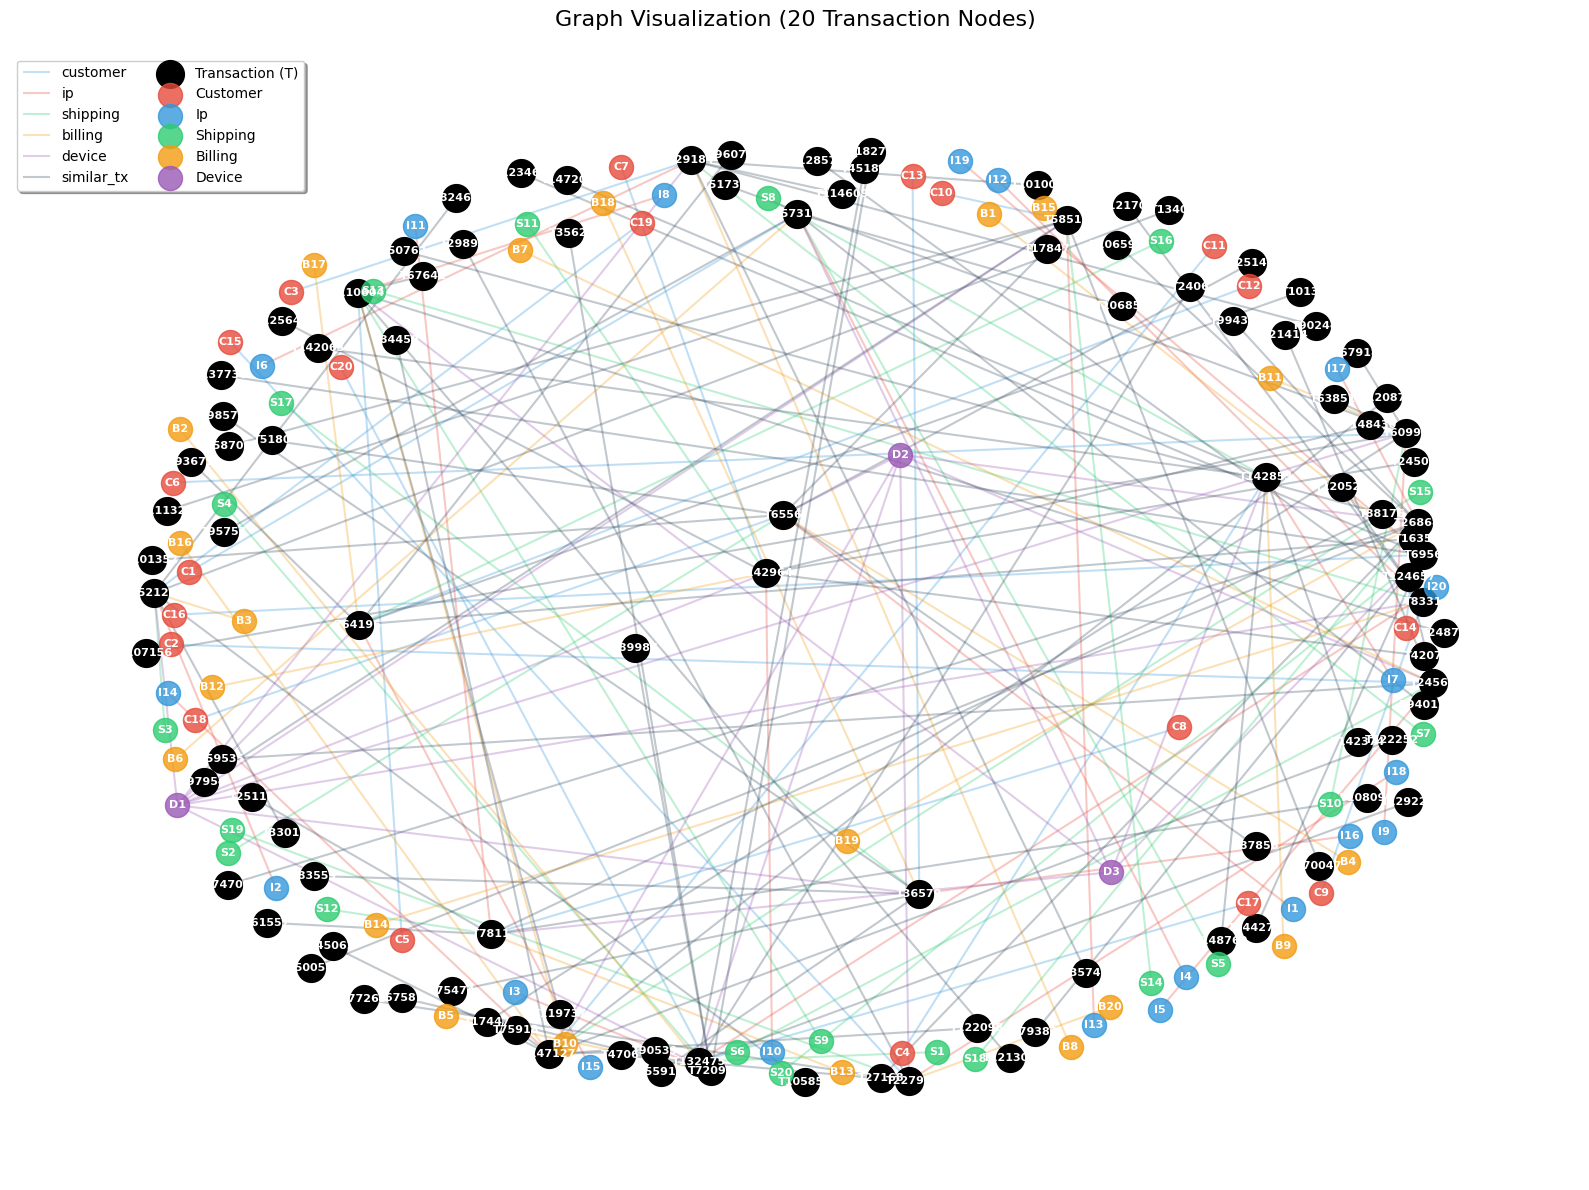

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import random

EDGE_TYPE_MAP = {
    0: "customer",
    1: "ip",
    2: "shipping",
    3: "billing",
    4: "device",
    5: "similar_tx"
}

EDGE_COLOR_MAP = {
    0: "#3498db",  # blue
    1: "#e74c3c",  # red
    2: "#2ecc71",  # green
    3: "#f39c12",  # orange
    4: "#9b59b6",  # purple
    5: "#34495e"   # dark gray
}

NODE_COLOR_MAP = {
    "customer": "#e74c3c",
    "ip": "#3498db",
    "shipping": "#2ecc71",
    "billing": "#f39c12",
    "device": "#9b59b6",
    "similar_tx": "#1abc9c"
}

def plot_graph_samples(data, num_tx_samples=20, seed=42):
    random.seed(seed)
    
    edge_index = data.edge_index.cpu().numpy()
    edge_type = data.edge_type.cpu().numpy()
    n_tx = data.n_transactions
    
    # Sample transaction nodes
    tx_nodes = random.sample(range(n_tx), min(num_tx_samples, n_tx))
    
    # Collect nodes & edges (1-hop)
    nodes = set(tx_nodes)
    edges = []
    entity_types = {}  # Track entity types
    
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        if src in tx_nodes or dst in tx_nodes:
            nodes.add(src)
            nodes.add(dst)
            edges.append((src, dst, edge_type[i]))
            
            # Track entity type based on edge type
            entity_node = dst if dst >= n_tx else (src if src >= n_tx else None)
            if entity_node is not None and entity_node not in entity_types:
                entity_types[entity_node] = EDGE_TYPE_MAP[edge_type[i]]
    
    # Build NetworkX graph
    G = nx.Graph()
    for n in nodes:
        if n < n_tx:
            G.add_node(n, node_type="tx")
        else:
            G.add_node(n, node_type=entity_types.get(n, "entity"))
    
    for src, dst, et in edges:
        G.add_edge(src, dst, edge_type=et)
    
    # Create figure
    plt.figure(figsize=(16, 12))
    
    # Layout with better spacing
    pos = nx.spring_layout(G, seed=seed, k=1.5, iterations=50)
    
    # Draw edges by type (draw first so they're behind nodes)
    for et, color in EDGE_COLOR_MAP.items():
        et_edges = [(u, v) for u, v, d in G.edges(data=True) if d["edge_type"] == et]
        if et_edges:
            nx.draw_networkx_edges(
                G, pos, 
                edgelist=et_edges, 
                edge_color=color, 
                alpha=0.3,
                width=1.5,
                label=EDGE_TYPE_MAP[et]
            )
    
    # Group nodes by type
    tx_nodes_plot = [n for n in G.nodes if G.nodes[n]["node_type"] == "tx"]
    
    # Draw transaction nodes (black circles)
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=tx_nodes_plot,
        node_color="black",
        node_size=400,
        label="Transaction (T)",
        node_shape='o'
    )
    
    # Draw entity nodes by type with different colors
    for entity_type, color in NODE_COLOR_MAP.items():
        entity_nodes = [n for n in G.nodes 
                       if G.nodes[n]["node_type"] == entity_type]
        if entity_nodes:
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=entity_nodes,
                node_color=color,
                node_size=300,
                label=f"{entity_type.capitalize()}",
                alpha=0.8
            )
    
    # Add labels with abbreviated names
    labels = {}
    entity_counters = {et: 0 for et in EDGE_TYPE_MAP.values()}
    
    for n in G.nodes:
        if G.nodes[n]["node_type"] == "tx":
            labels[n] = f"T{n}"
        else:
            entity_type = G.nodes[n]["node_type"]
            entity_counters[entity_type] += 1
            prefix = entity_type[0].upper()
            labels[n] = f"{prefix}{entity_counters[entity_type]}"
    
    nx.draw_networkx_labels(
        G, pos, 
        labels, 
        font_size=8,
        font_color="white",
        font_weight="bold"
    )
    
    plt.title("Graph Visualization (20 Transaction Nodes)", fontsize=16, pad=20)
    plt.axis("off")
    
    # Create legend
    plt.legend(
        loc='upper left',
        bbox_to_anchor=(0, 1),
        ncol=2,
        fontsize=10,
        frameon=True,
        fancybox=True,
        shadow=True
    )
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_graph_samples(train_graph_gnn, num_tx_samples=20)

### **GraphSAGE Encoder**

In [ ]:
class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes=2, dropout=0.3, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # GraphSAGE layers
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        # Embedding layer (before classification)
        self.embedding_dim = hidden_channels
        
        # Classification head
        self.classifier = nn.Linear(hidden_channels, num_classes)
        
    def forward(self, x, edge_index, return_embedding=False):
        # Apply GraphSAGE layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            if i < len(self.convs) - 1:  # Don't dropout after last layer
                x = F.dropout(x, p=self.dropout, training=self.training)
        
        # x is now the embedding
        if return_embedding:
            return x
        
        # Classification
        out = self.classifier(x)
        return out
    
    def get_embedding(self, x, edge_index):
        return self.forward(x, edge_index, return_embedding=True)

In [ ]:
def train_graph_autoencoder(data, embedding_dim=32, epochs=50, lr=0.01, 
                           weight_decay=1e-4, use_focal_loss=True):
    """
    Train supervised GraphSAGE for fraud detection with class imbalance handling.
    
    Args:
        data: PyG Data object with transaction and entity nodes
        embedding_dim: dimension of node embeddings (hidden_channels)
        epochs: number of training epochs
        lr: learning rate
        weight_decay: L2 regularization
        use_focal_loss: whether to use focal loss (better for imbalanced data)
    
    Returns:
        Trained encoder model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    
    # Move data to device
    data = data.to(device)
    
    # Calculate class weights for imbalanced data
    if data.y is not None:
        train_labels = data.y[data.train_mask]
        fraud_count = (train_labels == 1).sum().item()
        non_fraud_count = (train_labels == 0).sum().item()
        
        # Calculate pos_weight (how much to weight the positive class)
        pos_weight = non_fraud_count / fraud_count if fraud_count > 0 else 1.0
        pos_weight_tensor = torch.tensor([pos_weight], device=device)
        
        print(f"Class distribution: Non-fraud={non_fraud_count}, Fraud={fraud_count}")
        print(f"Positive class weight: {pos_weight:.2f}")
    else:
        pos_weight_tensor = None
    
    # Initialize model
    in_channels = data.x.shape[1]
    model = GraphSAGEClassifier(
        in_channels=in_channels,
        hidden_channels=embedding_dim,
        num_classes=2,
        dropout=0.3,
        num_layers=3  # 3 layers for better expressiveness
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Focal loss for imbalanced classification
    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.25, gamma=2.0):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
        
        def forward(self, inputs, targets):
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
            return focal_loss.mean()
    
    if use_focal_loss:
        criterion = FocalLoss(alpha=0.25, gamma=2.0)
    else:
        criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
    
    # Training loop
    model.train()
    best_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index)
        
        # Only compute loss on transaction nodes (not entity nodes)
        train_out = out[data.train_mask]
        train_labels = data.y[data.train_mask]
        
        # Filter out entity nodes (labeled as -1)
        valid_mask = train_labels >= 0
        train_out = train_out[valid_mask]
        train_labels = train_labels[valid_mask]
        
        # Compute loss
        loss = criterion(train_out, train_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        with torch.no_grad():
            pred = train_out.argmax(dim=1)
            acc = (pred == train_labels).float().mean().item()
            
            # Calculate F1 for fraud class
            tp = ((pred == 1) & (train_labels == 1)).sum().item()
            fp = ((pred == 1) & (train_labels == 0)).sum().item()
            fn = ((pred == 0) & (train_labels == 1)).sum().item()
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")
        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.eval()
    return model.cpu(), None  # Return model and None (for compatibility with old code)


### **Generating GNN Embeddings**

In [ ]:
print("\n===== TRAINING GNN ENCODER =====")
embedding_dim = 16
encoder_gnn, decoder_gnn = train_graph_autoencoder(
    train_graph_gnn, 
    embedding_dim=embedding_dim, 
    epochs=30, 
    lr=0.01
)
print("✓ GNN encoder trained")

### **Generating GNN Embeddings**

print("\n===== GENERATING GNN EMBEDDINGS =====")
with torch.no_grad():
    # Generate embeddings for all nodes in the graphs
    train_emb_all_nodes = encoder_gnn(train_graph_gnn.x, train_graph_gnn.edge_index).numpy()
    test_emb_all_nodes = encoder_gnn(test_graph_gnn.x, test_graph_gnn.edge_index).numpy()

# Extract embeddings only for transaction nodes (first n_transactions nodes)
# The graph structure has transaction nodes first, followed by entity nodes
n_train_transactions = len(X_train_scaled_gnn)
n_test_transactions = len(X_test_scaled_gnn)

train_emb_gnn = train_emb_all_nodes[:n_train_transactions]
test_emb_gnn = test_emb_all_nodes[:n_test_transactions]

print(f"All nodes embeddings shape - Train: {train_emb_all_nodes.shape}, Test: {test_emb_all_nodes.shape}")
print(f"Transaction embeddings shape - Train: {train_emb_gnn.shape}, Test: {test_emb_gnn.shape}")
print(f"Scaled features shape - Train: {X_train_scaled_gnn.shape}, Val: {X_val_scaled_gnn.shape}, Test: {X_test_scaled_gnn.shape}")

# Concatenate embeddings to the scaled tabular features
X_train_with_gnn = np.concatenate([X_train_scaled_gnn.values, train_emb_gnn], axis=1)
X_val_with_gnn = np.concatenate([X_val_scaled_gnn.values, train_emb_gnn[:len(X_val_scaled_gnn)]], axis=1)
X_test_with_gnn = np.concatenate([X_test_scaled_gnn.values, test_emb_gnn], axis=1)

# Build DataFrames
tab_cols = X_train_scaled_gnn.columns.tolist()
emb_cols = [f"gnn_emb_{i}" for i in range(train_emb_gnn.shape[1])]

X_train_with_gnn_df = pd.DataFrame(X_train_with_gnn, columns=tab_cols + emb_cols)
X_val_with_gnn_df = pd.DataFrame(X_val_with_gnn, columns=tab_cols + emb_cols)
X_test_with_gnn_df = pd.DataFrame(X_test_with_gnn, columns=tab_cols + emb_cols)

print("✓ GNN embeddings concatenated.")
print("Train shape:", X_train_with_gnn_df.shape)
print("Val shape:", X_val_with_gnn_df.shape)
print("Test shape:", X_test_with_gnn_df.shape)


===== TRAINING GNN ENCODER =====
Training on device: cpu
Class distribution: Non-fraud=59542, Fraud=15028
Positive class weight: 3.96
Epoch 5/30 - Loss: 0.0337, Acc: 0.7985, F1: 0.0000
Epoch 10/30 - Loss: 0.0320, Acc: 0.7985, F1: 0.0000
Epoch 15/30 - Loss: 0.0314, Acc: 0.7985, F1: 0.0000
Epoch 20/30 - Loss: 0.0304, Acc: 0.7985, F1: 0.0000
Epoch 25/30 - Loss: 0.0289, Acc: 0.7985, F1: 0.0000
Epoch 30/30 - Loss: 0.0278, Acc: 0.7985, F1: 0.0000
✓ GNN encoder trained

===== GENERATING GNN EMBEDDINGS =====
All nodes embeddings shape - Train: (372852, 2), Test: (116843, 2)
Transaction embeddings shape - Train: (74570, 2), Test: (23368, 2)
Scaled features shape - Train: (74570, 25), Val: (19791, 25), Test: (23368, 25)
✓ GNN embeddings concatenated.
Train shape: (74570, 27)
Val shape: (19791, 27)
Test shape: (23368, 27)


# **Modelling**

## **Without GNN**

### **5-Fold Cross Validation**

In [132]:
USE_CROSS_VAL = True
def evaluate_cv(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {"f1": [], "precision": [], "recall": [], "accuracy": [], "roc_auc": []}

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_va)

        # predict_proba fallback
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_va)[:, 1]
        else:
            y_proba = y_pred

        metrics["f1"].append(f1_score(y_va, y_pred))
        metrics["precision"].append(precision_score(y_va, y_pred, zero_division=0))
        metrics["recall"].append(recall_score(y_va, y_pred, zero_division=0))
        metrics["accuracy"].append(accuracy_score(y_va, y_pred))
        try:
            metrics["roc_auc"].append(roc_auc_score(y_va, y_proba))
        except Exception:
            metrics["roc_auc"].append(np.nan)

        print(f"  Fold {fold}: F1={metrics['f1'][-1]:.4f}, ROC-AUC={metrics['roc_auc'][-1] if not np.isnan(metrics['roc_auc'][-1]) else 'nan'}")

    avg = {k: np.nanmean(v) for k, v in metrics.items()}
    return avg


### **Hyperparameter Tuning Configuration**

In [133]:
# Control hyperparameter tuning
USE_HYPERPARAMETER_TUNING = True  # Set to False to skip tuning and use default hyperparameters

# Define hyperparameter grids for each model
param_grids = {
    "ANN": {
        'hidden_layer_sizes': [(64, 32), (128, 64, 32), (256, 128, 64)],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [300, 500]
    },
    
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.03, 0.1],
        'max_depth': [3, 6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2]
    },
    
    "LightGBM": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.03, 0.1],
        'max_depth': [3, 6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'num_leaves': [31, 50, 70]
    },
    
    "CatBoost": {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.03, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7]
    }
}

print("Hyperparameter grids defined for all models.")

Hyperparameter grids defined for all models.


### **Perform Hyperparameter Tuning**

In [134]:
# Store best parameters for each model
best_params = {}

if USE_HYPERPARAMETER_TUNING:
    print("\n===== HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH =====")
    print("This may take several minutes...\n")
    
    # Define base models for tuning
    base_models = {
        "ANN": MLPClassifier(random_state=42, early_stopping=True),
        "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMClassifier(
            is_unbalance=True,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        "CatBoost": CatBoostClassifier(
            auto_class_weights='Balanced',
            verbose=False,
            random_state=42
        )
    }
    
    # Perform RandomizedSearchCV for each model
    for name, base_model in base_models.items():
        print(f"Tuning {name}...")
        
        # Use RandomizedSearchCV (faster than GridSearchCV)
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grids[name],
            n_iter=20,  # Number of parameter settings sampled
            cv=3,  # 3-fold cross-validation
            scoring='f1',  # Optimize for F1 score
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        # Fit on training data
        random_search.fit(X_train_scaled, y_train_clean)
        
        # Store best parameters
        best_params[name] = random_search.best_params_
        
        print(f"  ✓ Best F1 Score: {random_search.best_score_:.4f}")
        print(f"  ✓ Best Parameters: {random_search.best_params_}\n")
    
    print("Hyperparameter tuning completed!")
else:
    print("\n===== SKIPPING HYPERPARAMETER TUNING (USE_HYPERPARAMETER_TUNING=False) =====")
    print("Using default hyperparameters for all models.\n")


===== HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH =====
This may take several minutes...

Tuning ANN...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.7964
  ✓ Best Parameters: {'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (256, 128, 64), 'alpha': 0.001}

Tuning RandomForest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.8190
  ✓ Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

Tuning XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.8088
  ✓ Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.9}

Tuning LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.7878
  ✓ Best Parameters: {'subsample': 0.7, 'num_leaves': 50, 'n_estimators': 200, 'max_depth':

In [135]:
# Build models with best hyperparameters (if tuning was performed)
if USE_HYPERPARAMETER_TUNING and best_params:
    print("Building models with tuned hyperparameters...\n")
    
    models = {
        "ANN": MLPClassifier(
            **best_params.get("ANN", {}),
            random_state=42,
            early_stopping=True
        ),
        "RandomForest": RandomForestClassifier(
            **best_params.get("RandomForest", {}),
            random_state=42,
            n_jobs=-1
        ),
        "XGBoost": XGBClassifier(
            **best_params.get("XGBoost", {}),
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMClassifier(
            **best_params.get("LightGBM", {}),
            is_unbalance=True,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        "CatBoost": CatBoostClassifier(
            **best_params.get("CatBoost", {}),
            auto_class_weights='Balanced',
            verbose=False,
            random_state=42
        )
    }
else:
    # Use default hyperparameters
    print("Building models with default hyperparameters...\n")
    
    models = {
        "ANN": MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                             max_iter=300, random_state=42, early_stopping=True),
        "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10,
                                               random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            is_unbalance=True,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        "CatBoost": CatBoostClassifier(
            iterations=300,
            depth=8,
            learning_rate=0.03,
            auto_class_weights='Balanced',
            verbose=False,
            random_state=42
        )
    }

cv_no_gnn_results = {}
val_no_gnn_results = {}

Building models with tuned hyperparameters...



### **Best Hyperparameters Summary**

In [136]:
# Display best hyperparameters found during tuning
if USE_HYPERPARAMETER_TUNING and best_params:
    print("=" * 80)
    print("BEST HYPERPARAMETERS FOUND")
    print("=" * 80)
    
    for model_name, params in best_params.items():
        print(f"\n{model_name}:")
        print("-" * 40)
        for param_name, param_value in params.items():
            print(f"  {param_name}: {param_value}")
    
    print("\n" + "=" * 80)
    
    # Create a DataFrame for better visualization
    import pandas as pd
    
    # Convert best_params to a more readable format
    params_list = []
    for model_name, params in best_params.items():
        for param_name, param_value in params.items():
            params_list.append({
                'Model': model_name,
                'Parameter': param_name,
                'Best Value': param_value
            })
    
    if params_list:
        best_params_df = pd.DataFrame(params_list)
        print("\nBest Hyperparameters DataFrame:")
        print(best_params_df.to_string(index=False))
else:
    print("Hyperparameter tuning was not performed or no parameters were found.")

BEST HYPERPARAMETERS FOUND

ANN:
----------------------------------------
  max_iter: 300
  learning_rate_init: 0.01
  hidden_layer_sizes: (256, 128, 64)
  alpha: 0.001

RandomForest:
----------------------------------------
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: None

XGBoost:
----------------------------------------
  subsample: 0.7
  n_estimators: 200
  max_depth: 10
  learning_rate: 0.03
  gamma: 0
  colsample_bytree: 0.9

LightGBM:
----------------------------------------
  subsample: 0.7
  num_leaves: 50
  n_estimators: 200
  max_depth: 8
  learning_rate: 0.01
  colsample_bytree: 0.9

CatBoost:
----------------------------------------
  learning_rate: 0.01
  l2_leaf_reg: 5
  iterations: 100
  depth: 8


Best Hyperparameters DataFrame:
       Model          Parameter     Best Value
         ANN           max_iter            300
         ANN learning_rate_init           0.01
         ANN hidden_layer_sizes (256, 128, 64)
 

### **Training**


===== 5-FOLD CV ON RESAMPLED TRAINING SET =====

-- ANN --
  Fold 1: F1=0.8670, ROC-AUC=0.9495027204528608
  Fold 2: F1=0.8692, ROC-AUC=0.95035436978324
  Fold 3: F1=0.8602, ROC-AUC=0.9453585825628563
  Fold 4: F1=0.8660, ROC-AUC=0.9497811842245023
  Fold 5: F1=0.8647, ROC-AUC=0.9466544651845034
 Avg -> F1: 0.8654, Precision: 0.9556, Recall: 0.7909, Acc: 0.9521, ROC-AUC: 0.9483

-- RandomForest --
  Fold 1: F1=0.8857, ROC-AUC=0.9560906059457437
  Fold 2: F1=0.8968, ROC-AUC=0.9597445110850283
  Fold 3: F1=0.8813, ROC-AUC=0.9560078889795883
  Fold 4: F1=0.8951, ROC-AUC=0.9609953154668788
  Fold 5: F1=0.8847, ROC-AUC=0.9548699229880406
 Avg -> F1: 0.8887, Precision: 0.9612, Recall: 0.8265, Acc: 0.9597, ROC-AUC: 0.9575

-- XGBoost --
  Fold 1: F1=0.8869, ROC-AUC=0.9590000333791333
  Fold 2: F1=0.8958, ROC-AUC=0.9609564036423053
  Fold 3: F1=0.8784, ROC-AUC=0.9572989381742761
  Fold 4: F1=0.8913, ROC-AUC=0.9621778731326012
  Fold 5: F1=0.8845, ROC-AUC=0.9556196497145346
 Avg -> F1: 0.8874,

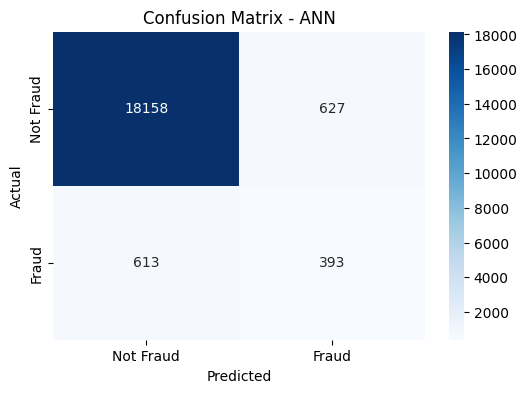


--> Final training and evaluation: RandomForest
Accuracy: 0.9418
Confusion Matrix:
 [[18282   503]
 [  649   357]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     18785
           1       0.42      0.35      0.38      1006

    accuracy                           0.94     19791
   macro avg       0.69      0.66      0.68     19791
weighted avg       0.94      0.94      0.94     19791



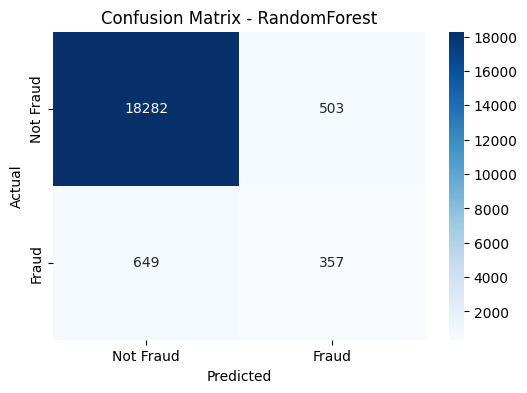


--> Final training and evaluation: XGBoost
Accuracy: 0.9421
Confusion Matrix:
 [[18271   514]
 [  631   375]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     18785
           1       0.42      0.37      0.40      1006

    accuracy                           0.94     19791
   macro avg       0.69      0.67      0.68     19791
weighted avg       0.94      0.94      0.94     19791



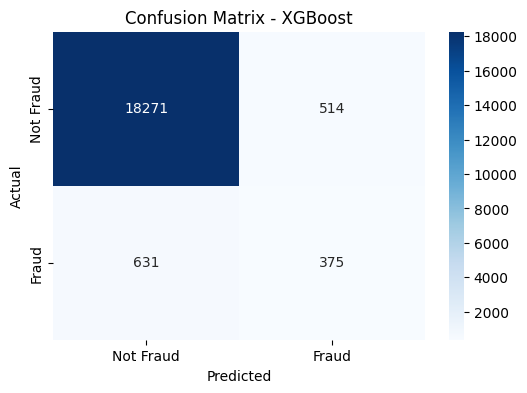


--> Final training and evaluation: LightGBM
Accuracy: 0.9100
Confusion Matrix:
 [[17499  1286]
 [  496   510]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     18785
           1       0.28      0.51      0.36      1006

    accuracy                           0.91     19791
   macro avg       0.63      0.72      0.66     19791
weighted avg       0.94      0.91      0.92     19791



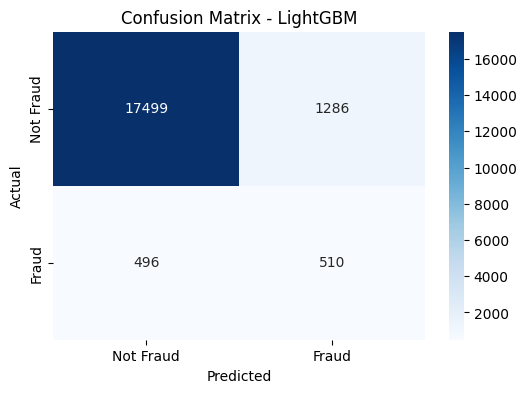


--> Final training and evaluation: CatBoost
Accuracy: 0.8824
Confusion Matrix:
 [[16878  1907]
 [  421   585]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     18785
           1       0.23      0.58      0.33      1006

    accuracy                           0.88     19791
   macro avg       0.61      0.74      0.63     19791
weighted avg       0.94      0.88      0.90     19791



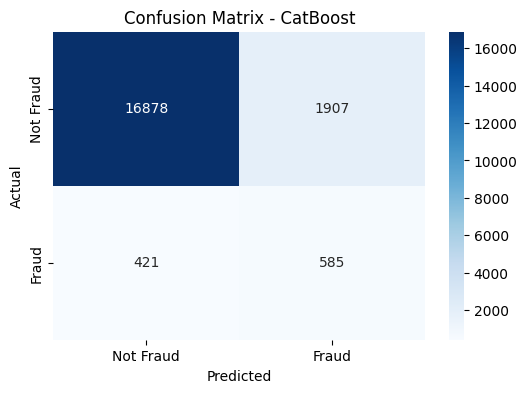


===== VALIDATION (HOLD-OUT) METRICS =====


,f1,precision,recall,accuracy,roc_auc
ANN,0.387957,0.385294,0.390656,0.937345,0.803966
RandomForest,0.382637,0.415116,0.354871,0.941792,0.800175
XGBoost,0.395778,0.421822,0.372763,0.942145,0.812883
LightGBM,0.364026,0.283964,0.506958,0.909959,0.813687
CatBoost,0.334477,0.234751,0.581511,0.882371,0.816827


In [137]:
if USE_CROSS_VAL:
    print("\n===== 5-FOLD CV ON RESAMPLED TRAINING SET =====")
    for name, mdl in models.items():
        print(f"\n-- {name} --")
        avg_metrics = evaluate_cv(mdl, X_train_scaled, y_train_clean, n_splits=5)
        cv_no_gnn_results[name] = avg_metrics
        print(f" Avg -> F1: {avg_metrics['f1']:.4f}, Precision: {avg_metrics['precision']:.4f}, "
              f"Recall: {avg_metrics['recall']:.4f}, Acc: {avg_metrics['accuracy']:.4f}, ROC-AUC: {avg_metrics['roc_auc']:.4f}")
else:
    print("\n===== SKIPPING CROSS-VALIDATION (use_cross_val=False) =====")

# === FINAL TRAINING & VALIDATION ===
test_preds_df = X_test_scaled.copy().reset_index(drop=True)
print("\n===== TRAIN FINAL MODELS ON FULL RESAMPLED TRAINING SET & EVALUATE ON HOLD-OUT VALIDATION =====")

results_summary = []

for name, mdl in models.items():
    print(f"\n--> Final training and evaluation: {name}")
    mdl.fit(X_train_scaled, y_train_clean)

    # Predictions
    y_val_pred = mdl.predict(X_val_scaled)
    if hasattr(mdl, "predict_proba"):
        y_val_proba = mdl.predict_proba(X_val_scaled)[:, 1]
    else:
        y_val_proba = y_val_pred

    # Compute metrics
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, zero_division=0)
    rec = recall_score(y_val, y_val_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_val_proba) if len(np.unique(y_val_proba)) > 1 else np.nan
    cm = confusion_matrix(y_val, y_val_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_val, y_val_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Store metrics
    val_metrics = {
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "accuracy": acc,
        "roc_auc": roc_auc
    }
    val_no_gnn_results[name] = val_metrics
    results_summary.append((name, acc, f1, prec, rec, roc_auc))

    # Predictions on test
    if hasattr(mdl, "predict_proba"):
        test_probs = mdl.predict_proba(X_test_scaled)[:, 1]
    else:
        test_probs = mdl.predict(X_test_scaled)

    test_preds_df[f"{name}_prob"] = test_probs
    test_preds_df[f"{name}_pred"] = (test_probs >= 0.5).astype(int)

# Display tabular summary
val_no_gnn_summary = pd.DataFrame(val_no_gnn_results).T
print("\n===== VALIDATION (HOLD-OUT) METRICS =====")
display(val_no_gnn_summary)


### **Model Summary**

In [138]:
# CV summary
cv_no_gnn_summary = pd.DataFrame(cv_no_gnn_results).T
print("\nCV AVERAGE METRICS (5-fold on resampled train):")
display(cv_no_gnn_summary)

# Validation summary
val_no_gnn_summary = pd.DataFrame(val_no_gnn_results).T
print("\nValidation (hold-out) metrics:")
display(val_no_gnn_summary)



CV AVERAGE METRICS (5-fold on resampled train):


,f1,precision,recall,accuracy,roc_auc
ANN,0.865429,0.955553,0.790857,0.952135,0.948330
RandomForest,0.888742,0.961165,0.826524,0.959737,0.957542
XGBoost,0.887379,0.963003,0.822797,0.959361,0.959011
LightGBM,0.854507,0.864464,0.844823,0.944015,0.953660
CatBoost,0.823078,0.779940,0.871307,0.927102,0.953685



Validation (hold-out) metrics:


,f1,precision,recall,accuracy,roc_auc
ANN,0.387957,0.385294,0.390656,0.937345,0.803966
RandomForest,0.382637,0.415116,0.354871,0.941792,0.800175
XGBoost,0.395778,0.421822,0.372763,0.942145,0.812883
LightGBM,0.364026,0.283964,0.506958,0.909959,0.813687
CatBoost,0.334477,0.234751,0.581511,0.882371,0.816827


## **With GNN**

### **5-Fold Cross Validation**

In [113]:
USE_CROSS_VAL = True
def evaluate_cv(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {"f1": [], "precision": [], "recall": [], "accuracy": [], "roc_auc": []}

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_va)

        # predict_proba fallback
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_va)[:, 1]
        else:
            y_proba = y_pred

        metrics["f1"].append(f1_score(y_va, y_pred))
        metrics["precision"].append(precision_score(y_va, y_pred, zero_division=0))
        metrics["recall"].append(recall_score(y_va, y_pred, zero_division=0))
        metrics["accuracy"].append(accuracy_score(y_va, y_pred))
        try:
            metrics["roc_auc"].append(roc_auc_score(y_va, y_proba))
        except Exception:
            metrics["roc_auc"].append(np.nan)

        print(f"  Fold {fold}: F1={metrics['f1'][-1]:.4f}, ROC-AUC={metrics['roc_auc'][-1] if not np.isnan(metrics['roc_auc'][-1]) else 'nan'}")

    avg = {k: np.nanmean(v) for k, v in metrics.items()}
    return avg

### **Hyperparameter Tuning Configuration**

In [114]:
USE_HYPERPARAMETER_TUNING = True  # Set to False to skip tuning and use default hyperparameters

# Define hyperparameter grids for each model
param_grids_gnn = {
    "ANN": {
        'hidden_layer_sizes': [(64, 32), (128, 64, 32), (256, 128, 64)],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [300, 500]
    },
    
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.03, 0.1],
        'max_depth': [3, 6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2]
    },
    
    "LightGBM": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.03, 0.1],
        'max_depth': [3, 6, 8, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'num_leaves': [31, 50, 70]
    },
    
    "CatBoost": {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.03, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7]
    }
}

print("Hyperparameter grids defined for all models (GNN).")

Hyperparameter grids defined for all models (GNN).


### **Perform Hyperparameter Tuning**

In [115]:
best_params_gnn = {}

if USE_HYPERPARAMETER_TUNING:
    print("\n===== HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH (GNN) =====")
    print("This may take several minutes...\n")
    
    # Define base models for tuning
    base_models_gnn = {
        "ANN": MLPClassifier(random_state=42, early_stopping=True),
        "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMClassifier(
            is_unbalance=True,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        "CatBoost": CatBoostClassifier(
            auto_class_weights='Balanced',
            verbose=False,
            random_state=42
        )
    }
    
    # Perform RandomizedSearchCV for each model
    for name, base_model in base_models_gnn.items():
        print(f"Tuning {name}...")
        
        # Use RandomizedSearchCV (faster than GridSearchCV)
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grids_gnn[name],
            n_iter=20,  # Number of parameter settings sampled
            cv=3,  # 3-fold cross-validation
            scoring='f1',  # Optimize for F1 score
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        
        # Fit on training data
        random_search.fit(X_train_with_gnn_df, y_train_clean_gnn)
        
        # Store best parameters
        best_params_gnn[name] = random_search.best_params_
        
        print(f"  ✓ Best F1 Score: {random_search.best_score_:.4f}")
        print(f"  ✓ Best Parameters: {random_search.best_params_}\n")
    
    print("Hyperparameter tuning completed!")
else:
    print("\n===== SKIPPING HYPERPARAMETER TUNING (USE_HYPERPARAMETER_TUNING=False) =====")
    print("Using default hyperparameters for all models.\n")



===== HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH (GNN) =====
This may take several minutes...

Tuning ANN...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.7795
  ✓ Best Parameters: {'max_iter': 500, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (64, 32), 'alpha': 0.0001}

Tuning RandomForest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.7994
  ✓ Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

Tuning XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.7867
  ✓ Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}

Tuning LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  ✓ Best F1 Score: 0.7548
  ✓ Best Parameters: {'subsample': 0.9, 'num_leaves': 50, 'n_estimators': 300, 'max_depth'

### **Best Hyperparameters Summary**

In [116]:
if USE_HYPERPARAMETER_TUNING and best_params_gnn:
    print("Building models with tuned hyperparameters (GNN)...\n")
    
    models_gnn = {
        "ANN": MLPClassifier(
            **best_params_gnn.get("ANN", {}),
            random_state=42,
            early_stopping=True
        ),
        "RandomForest": RandomForestClassifier(
            **best_params_gnn.get("RandomForest", {}),
            random_state=42,
            n_jobs=-1
        ),
        "XGBoost": XGBClassifier(
            **best_params_gnn.get("XGBoost", {}),
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMClassifier(
            **best_params_gnn.get("LightGBM", {}),
            is_unbalance=True,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        "CatBoost": CatBoostClassifier(
            **best_params_gnn.get("CatBoost", {}),
            auto_class_weights='Balanced',
            verbose=False,
            random_state=42
        )
    }
else:
    # Use default hyperparameters
    print("Building models with default hyperparameters (GNN)...\n")
    
    models_gnn = {
        "ANN": MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                             max_iter=300, random_state=42, early_stopping=True),
        "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10,
                                               random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            is_unbalance=True,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        "CatBoost": CatBoostClassifier(
            iterations=300,
            depth=8,
            learning_rate=0.03,
            auto_class_weights='Balanced',
            verbose=False,
            random_state=42
        )
    }

cv_gnn_results = {}
val_gnn_results = {}

Building models with tuned hyperparameters (GNN)...



### **Training**


===== TRAIN FINAL MODELS ON FULL RESAMPLED TRAINING SET & EVALUATE ON HOLD-OUT VALIDATION (GNN) =====

--> Final training and evaluation: ANN
Accuracy: 0.9362
Confusion Matrix:
 [[18204   581]
 [  681   325]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     18785
           1       0.36      0.32      0.34      1006

    accuracy                           0.94     19791
   macro avg       0.66      0.65      0.65     19791
weighted avg       0.93      0.94      0.93     19791



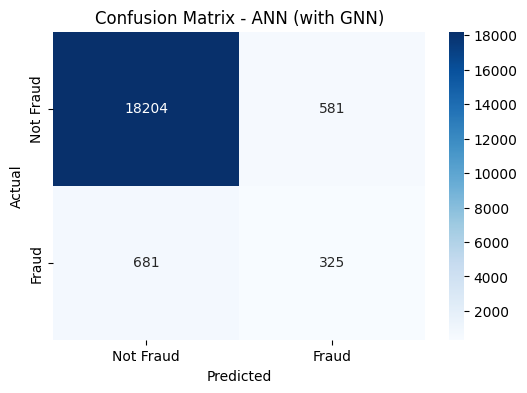


--> Final training and evaluation: RandomForest
Accuracy: 0.9505
Confusion Matrix:
 [[18667   118]
 [  862   144]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     18785
           1       0.55      0.14      0.23      1006

    accuracy                           0.95     19791
   macro avg       0.75      0.57      0.60     19791
weighted avg       0.94      0.95      0.94     19791



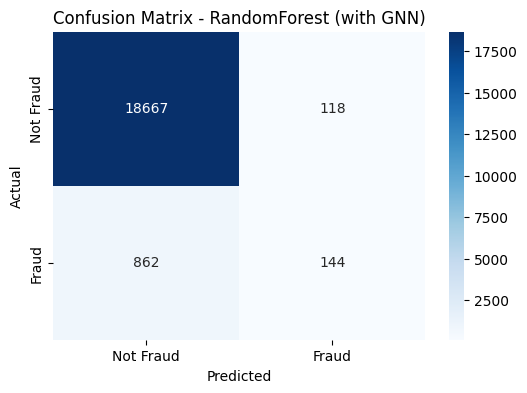


--> Final training and evaluation: XGBoost
Accuracy: 0.9509
Confusion Matrix:
 [[18688    97]
 [  874   132]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     18785
           1       0.58      0.13      0.21      1006

    accuracy                           0.95     19791
   macro avg       0.77      0.56      0.59     19791
weighted avg       0.94      0.95      0.94     19791



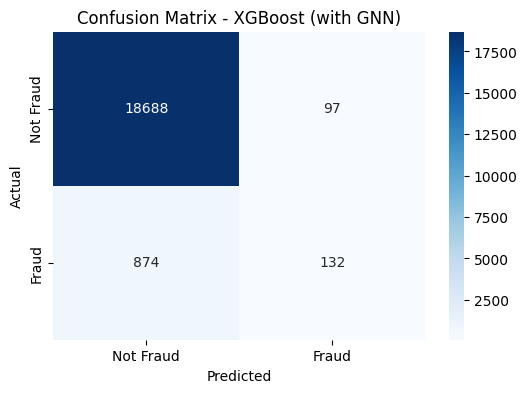


--> Final training and evaluation: LightGBM
Accuracy: 0.9375
Confusion Matrix:
 [[18335   450]
 [  787   219]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     18785
           1       0.33      0.22      0.26      1006

    accuracy                           0.94     19791
   macro avg       0.64      0.60      0.61     19791
weighted avg       0.93      0.94      0.93     19791



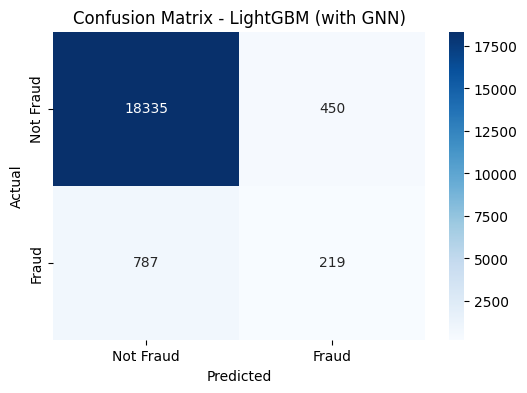


--> Final training and evaluation: CatBoost
Accuracy: 0.9413
Confusion Matrix:
 [[18444   341]
 [  821   185]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     18785
           1       0.35      0.18      0.24      1006

    accuracy                           0.94     19791
   macro avg       0.65      0.58      0.61     19791
weighted avg       0.93      0.94      0.93     19791



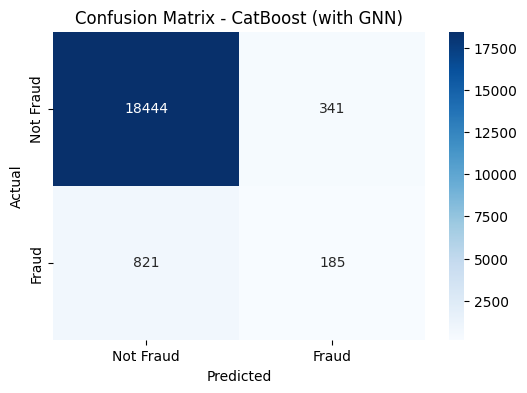

In [117]:
test_preds_gnn_df = X_test_with_gnn_df.copy().reset_index(drop=True)
print("\n===== TRAIN FINAL MODELS ON FULL RESAMPLED TRAINING SET & EVALUATE ON HOLD-OUT VALIDATION (GNN) =====")

results_summary_gnn = []

for name, mdl in models_gnn.items():
    print(f"\n--> Final training and evaluation: {name}")
    mdl.fit(X_train_with_gnn_df, y_train_clean_gnn)

    # Predictions
    y_val_pred = mdl.predict(X_val_with_gnn_df)
    if hasattr(mdl, "predict_proba"):
        y_val_proba = mdl.predict_proba(X_val_with_gnn_df)[:, 1]
    else:
        y_val_proba = y_val_pred

    # Compute metrics
    acc = accuracy_score(y_val_gnn, y_val_pred)
    f1 = f1_score(y_val_gnn, y_val_pred)
    prec = precision_score(y_val_gnn, y_val_pred, zero_division=0)
    rec = recall_score(y_val_gnn, y_val_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val_gnn, y_val_proba) if len(np.unique(y_val_proba)) > 1 else np.nan
    cm = confusion_matrix(y_val_gnn, y_val_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_val_gnn, y_val_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name} (with GNN)')
    plt.show()

    # Store metrics
    val_metrics = {
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "accuracy": acc,
        "roc_auc": roc_auc
    }
    val_gnn_results[name] = val_metrics

    # Predictions on test
    if hasattr(mdl, "predict_proba"):
        test_probs = mdl.predict_proba(X_test_with_gnn_df)[:, 1]
    else:
        test_probs = mdl.predict(X_test_with_gnn_df)

    test_preds_gnn_df[f"{name}_prob"] = test_probs
    test_preds_gnn_df[f"{name}_pred"] = (test_probs >= 0.5).astype(int)

### **Model Summary**

In [118]:
# CV summary
if USE_CROSS_VAL and cv_gnn_results:
    cv_gnn_summary = pd.DataFrame(cv_gnn_results).T
    print("\n" + "="*80)
    print("CV AVERAGE METRICS (5-fold on resampled train with GNN):")
    print("="*80)
    display(cv_gnn_summary)

# Validation summary
val_gnn_summary = pd.DataFrame(val_gnn_results).T
print("\n" + "="*80)
print("VALIDATION (HOLD-OUT) METRICS WITH GNN:")
print("="*80)
display(val_gnn_summary)


VALIDATION (HOLD-OUT) METRICS WITH GNN:


,f1,precision,recall,accuracy,roc_auc
ANN,0.339958,0.358720,0.323062,0.936234,0.789942
RandomForest,0.227129,0.549618,0.143141,0.950483,0.761037
XGBoost,0.213765,0.576419,0.131213,0.950937,0.759273
LightGBM,0.261493,0.327354,0.217694,0.937497,0.743980
CatBoost,0.241514,0.351711,0.183897,0.941286,0.740871


# **Comparison**

In [139]:
# Convert dicts to DataFrames
cv_no_gnn_df = pd.DataFrame(cv_no_gnn_results).T
val_no_gnn_df = pd.DataFrame(val_no_gnn_results).T
cv_gnn_df = pd.DataFrame(cv_gnn_results).T
val_gnn_df = pd.DataFrame(val_gnn_results).T

print("===== CV (5-Fold, Resampled Training Set) =====")
display(pd.concat({
    "No-GNN": cv_no_gnn_df,
    "With-GNN": cv_gnn_df
}, axis=1, keys=["No-GNN", "With-GNN"]))

print("\n===== Hold-out Validation Performance =====")
display(pd.concat({
    "No-GNN": val_no_gnn_df,
    "With-GNN": val_gnn_df
}, axis=1, keys=["No-GNN", "With-GNN"]))

# Optional: pretty summary comparison
def summarize_comparison(df_no_gnn, df_gnn, metric="f1"):
    summary = pd.DataFrame({
        "No-GNN": df_no_gnn[metric],
        "With-GNN": df_gnn[metric],
        "Δ (GNN - NoGNN)": df_gnn[metric] - df_no_gnn[metric]
    })
    summary = summary.sort_values(by="Δ (GNN - NoGNN)", ascending=False)
    return summary

print("\n===== Δ F1-SCORE COMPARISON (GNN - No-GNN) =====")
display(summarize_comparison(val_no_gnn_df, val_gnn_df, metric="f1"))


===== CV (5-Fold, Resampled Training Set) =====


No-GNN                                        
                    f1 precision    recall  accuracy   roc_auc
ANN           0.865429  0.955553  0.790857  0.952135  0.948330
RandomForest  0.888742  0.961165  0.826524  0.959737  0.957542
XGBoost       0.887379  0.963003  0.822797  0.959361  0.959011
LightGBM      0.854507  0.864464  0.844823  0.944015  0.953660
CatBoost      0.823078  0.779940  0.871307  0.927102  0.953685


===== Hold-out Validation Performance =====


No-GNN                                          With-GNN  \
                    f1 precision    recall  accuracy   roc_auc        f1   
ANN           0.387957  0.385294  0.390656  0.937345  0.803966  0.339958   
RandomForest  0.382637  0.415116  0.354871  0.941792  0.800175  0.227129   
XGBoost       0.395778  0.421822  0.372763  0.942145  0.812883  0.213765   
LightGBM      0.364026  0.283964  0.506958  0.909959  0.813687  0.261493   
CatBoost      0.334477  0.234751  0.581511  0.882371  0.816827  0.241514   

                                                      
             precision    recall  accuracy   roc_auc  
ANN           0.358720  0.323062  0.936234  0.789942  
RandomForest  0.549618  0.143141  0.950483  0.761037  
XGBoost       0.576419  0.131213  0.950937  0.759273  
LightGBM      0.327354  0.217694  0.937497  0.743980  
CatBoost      0.351711  0.183897  0.941286  0.740871


===== Δ F1-SCORE COMPARISON (GNN - No-GNN) =====


,No-GNN,With-GNN,Δ (GNN - NoGNN)
ANN,0.387957,0.339958,-0.047998
CatBoost,0.334477,0.241514,-0.092962
LightGBM,0.364026,0.261493,-0.102533
RandomForest,0.382637,0.227129,-0.155507
XGBoost,0.395778,0.213765,-0.182013
